Análisis de datos 
Laboratorio Avanzado II 
Estudiante: Esteban Vinicio Soto Monge


Fecha 20230619

In [5]:
#dependencies
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
import socket
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Main path location (The folder in which all measurements are saved)
main_path = r"C:\Users\esteb\electrochromicfilms\Edgar"


#working at
computer_name = socket.gethostname()
#computer_name = "colaboratory"
print(f"computer name: {computer_name}")
if computer_name == "CICIMA-EVSM":
    base_folder = r"C:\Users\EstebanSoto\electrochromicfilms"
elif computer_name == "Shannon":
    base_folder = r"C:\Users\esteb\electrochromicfilms"
elif computer_name == "colaboratory":
    base_folder = r""
elif computer_name == "ThinkPad-L440":
    base_folder = r"/home/vinicio/electrochromicfilms"
    
WIDTH = 15
HEIGHT = 6
img_counter = 0

computer name: CICIMA-EVSM


In [6]:
class PotentiostatFile:
        def __init__(self, file_path, type_of_file, date, film_area, min_transmittance = None, max_transmittance = None):
            self.file_path = file_path
            self.basename = os.path.basename(file_path)
            self.type_of_file = type_of_file
            self.film_area = film_area
            self.column_labels = self._get_column_labels(type_of_file)
            self.column_names = self._get_column_names(type_of_file)
            self.dataframe = self._read_file(file_path, self.column_names)
            self.min_transmittance = min_transmittance
            self.max_transmittance = max_transmittance
            self.data_processing()
            self.date = date

        def _get_column_labels(self, type_of_file):
            if type_of_file == "CV":
                return {"time": "Time (s)", "current": "Current (mA/$cm^2$)", "voltage": "Potential vs Ag/AgCl 3M ref (V)"}
            elif type_of_file == "CA":
                return {"time": "Time (s)", "current": "Current (mA/$cm^2$)", "voltage": "Potential vs Ag/AgCl 3M ref (V)"}
            elif type_of_file == "CA+":
                return {"time": "Time (s)", "voltage": "Potential vs Ag/AgCl 3M ref (V)", "current": "Current (mA/$cm^2$)", "transmittance":"Transmittance [%]"}
            elif type_of_file == "OCP":
                return {"time": "Time (s)", "voltage": "Potential vs Ag/AgCl 3M ref (V)"}
            elif type_of_file == "OCP+":
                return {"time": "Time (s)", "voltage": "Potential vs Ag/AgCl 3M ref (V)","transmittance":"Transmittance [V$_{external}$]"}
            elif type_of_file == "CV+":
                return {"time": "Time (s)", "scan": "Scan", "voltage": "Potential vs Ag/AgCl 3M ref (V)", "current":"Current (mA/$cm^2$)", "transmittance":"Transmittance [%]", "Q+":"Q+", "Q-":"Q-"}
            else:
                raise ValueError("Unsupported file type.")
                
        def _get_column_names(self, type_of_file):
            column_names_CV =  ["time", "voltage", "current"] 
            column_names_CA = ["time", "voltage", "current"] 
            column_names_CA_plus = ["time", "voltage", "current", "transmittance"] 
            column_names_OCP = ["time", "voltage"] 
            column_names_OCP_plus = ["time", "voltage", "transmittance"] 
            column_names_CV_plus = ["time", "scan", "voltage", "current", "transmittance", "Q+", "Q-"] 
            
            if type_of_file == "CV":
                return column_names_CV
            elif type_of_file == "CA":
                return column_names_CA
            elif type_of_file == "CA+":
                return column_names_CA_plus
            elif type_of_file == "OCP":
                return column_names_OCP
            elif type_of_file == "OCP+":
                return column_names_OCP_plus
            elif type_of_file == "CV+":
                return column_names_CV_plus
            else:
                raise ValueError("Unsupported file type.")
        
        def _read_file(self, file_path, column_labels):
            print(self.column_names)
            return pd.read_csv(file_path, sep="\t", names=self.column_names, header=0)
            
        def get_filename(self):
            return self.file_path.split('/')[-1]
        
        def get_max_transmittance(self):
            return self.dataframe["transmittance"].max()
        def get_min_transmittance(self):
            return self.dataframe["transmittance"].min()
        
        def set_max_transmittance(self, max_transmittance):
            self.max_transmittance = max_transmittance
        def set_min_transmittance(self, min_transmittance):
            self.min_transmittance = min_transmittance
        
        def saveimage(self, analysis_name):
            dirname = os.path.join(os.path.dirname(self.file_path), "images")
            try:
                os.makedirs(dirname)
            except Exception as e:
                print(e)
            img_counter = 0
            
            filename = os.path.join(dirname, f"{analysis_name} analysis for {self.basename} on {self.date} ({img_counter}).png")
            while os.path.exists(filename):
                img_counter = img_counter + 1
                filename = os.path.join(dirname, f"{analysis_name} for {self.basename} on {self.date} ({img_counter}).png")
            
            plt.savefig(filename)
            
        def time_vs_current_analysis(self, start = None, end = None, type = None, xlim = None, ylim = None):
            basename = os.path.basename(self.file_path)
            x = "time"
            y = "current"
            analysis_name = "current vs time analysis"
            df = self.dataframe
            df2 = df.copy(deep=True)
            #filter by time
            if start:
                df2 = df2.loc[df[x]>start,]
            if end:
                df2 = df2.loc[df[x]<end,]
            #markersizes
            n = len(df[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            plt.figure(figsize=(WIDTH,HEIGHT))
            if type == "scatter":
                df2.plot.scatter(x, y, grid=True, sizes= sizes)
            else:
                df2.plot(x, y)
                plt.grid()
            #plt.title(f"File {basename}. Date: {self.date}")
            if xlim: 
                plt.xlim(*xlim)  # Set x-axis limits
            if ylim: 
                plt.ylim(*ylim)  # Set y-axis limits
            plt.xlabel(self.column_labels[x])
            plt.ylabel(self.column_labels[y])
            self.saveimage(analysis_name)
            plt.show()
            
        def time_vs_voltage_analysis(self, start = None, end = None, type = None, xlim = None, ylim = None):
            basename = os.path.basename(self.file_path)
            x = "time"
            y = "voltage"
            analysis_name = "potential vs time analysis"
            df = self.dataframe
            df2 = df.copy(deep=True)
            #filter by time
            if start:
                df2 = df2.loc[df[x]>start,]
            if end:
                df2 = df2.loc[df[x]<end,]
            #markersizes
            n = len(df[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            plt.figure(figsize=(WIDTH,HEIGHT))
            if type == "scatter":
                df2.plot.scatter(x, y, grid=True, sizes= sizes)
            else:
                df2.plot(x, y)
                plt.grid()
            #plt.title(f"File {basename}. Date: {self.date}")
            if xlim: 
                plt.xlim(*xlim)  # Set x-axis limits
            if ylim: 
                plt.ylim(*ylim)  # Set y-axis limits
            plt.xlabel(self.column_labels[x])
            plt.ylabel(self.column_labels[y])
            self.saveimage(analysis_name)
            plt.show()
    
        def voltage_vs_current_analysis(self, start = None, end = None, type = None, xlim = None, ylim = None):
            basename = os.path.basename(self.file_path)
            x = "voltage"
            y = "current"
            analysis_name = "potential vs current analysis"
            df = self.dataframe
            df2 = df.copy(deep=True)
            #filter by time
            if start:
                df2 = df2.loc[df["time"]>start,]
            if end:
                df2 = df2.loc[df["time"]<end,]

            #markersizes
            n = len(df[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            plt.figure(figsize=(WIDTH,HEIGHT))
            if type == "scatter":
                df2.plot.scatter(x, y, grid=True, sizes= sizes)
            else:
                df2.plot(x, y)
                plt.grid()
            #plt.title(f"File {basename}. Date: {self.date}")
            if xlim: 
                plt.xlim(*xlim)  # Set x-axis limits
            if ylim: 
                plt.ylim(*ylim)  # Set y-axis limits
            plt.xlabel(self.column_labels[x])
            plt.ylabel(self.column_labels[y])
            self.saveimage(analysis_name)
            plt.show()

        def transmittance_vs_time_analysis(self, start = None, end = None, type = None, xlim = None, ylim = None):
            basename = os.path.basename(self.file_path)
            x = "time"
            y = "transmittance"
            analysis_name = "transmittance vs time analysis"
            df = self.dataframe
            df2 = df.copy(deep=True)
            
            #filter by time
            if start:
                df2 = df2.loc[df[x]>start,]
            if end:
                df2 = df2.loc[df[x]<end,]
            #markersizes
            n = len(df[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            plt.figure(figsize=(WIDTH,HEIGHT))
            if type == "scatter":
                df2.plot.scatter(x, y, grid=True, sizes= sizes)
            else:
                df2.plot(x, y)
                plt.grid()
            #plt.title(f"File {basename}. Date: {self.date}")
            if xlim: 
                plt.xlim(*xlim)  # Set x-axis limits
            if ylim: 
                plt.ylim(*ylim)  # Set y-axis limits
            plt.xlabel(self.column_labels[x])
            plt.ylabel(self.column_labels[y])
            self.saveimage(analysis_name)
            plt.show()
            
        def current_and_transmittance_vs_time_analysis(self, start = None, end = None, type = None, xlim1 = None, ylim1 = None,xlim2 = None, ylim2 = None ):
            basename = os.path.basename(self.file_path)
            x = "time"
            y = "transmittance"
            y2 = "current"
            analysis_name = "transmittance and current vs time analysis"
            df = self.dataframe
            df2 = df.copy(deep=True)
            
            #filter by time
            if start:
                df2 = df2.loc[df[x]>start,]
            if end:
                df2 = df2.loc[df[x]<end,]
            #markersizes
            n = len(df[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            plt.figure(figsize=(WIDTH,HEIGHT))
            if type == "scatter":
                df2.plot.scatter(x, y, grid=True, sizes= sizes)
                df2.plot.scatter(x, y2, grid=True, sizes= sizes)
            else:
                x_val = df2[x].values
                y_val = df2[y].values
                y2_val = df2[y2].values
                # Create figure and primary axis
                fig, ax1 = plt.subplots()
                
                # Plot data on primary axis
                ax1.plot(x_val, y_val, 'g-')
                ax1.set_xlabel(self.column_labels[x])
                ax1.set_ylabel(self.column_labels[y], color='g')
                
                # Create secondary axis
                ax2 = ax1.twinx()
                
                # Plot data on secondary axis
                ax2.plot(x_val, y2_val, 'b-')
                ax2.set_ylabel(self.column_labels[y2], color='b')
                
                #set limits
                if xlim1: 
                    ax1.set_xlim(*xlim1)  # Set x-axis limits
                if ylim1: 
                    ax1.set_ylim(*ylim1)  # Set y-axis limits
                    
                #set limits
                if xlim2: 
                    ax2.set_xlim(*xlim2)  # Set x-axis limits
                if ylim2: 
                    ax2.set_ylim(*ylim2)  # Set y-axis limits
                    
                plt.grid()
            #plt.title(f"File {basename}. Date: {self.date}")
            
            self.saveimage(analysis_name)
            plt.show()
        
        def voltage_and_current_vs_time_analysis(self, start = None, end = None, type = None, xlim1 = None, ylim1 = None,xlim2 = None, ylim2 = None ):
            basename = os.path.basename(self.file_path)
            x = "time"
            y = "voltage"
            y2 = "current"
            analysis_name = "voltage and current vs time analysis"
            df = self.dataframe
            df2 = df.copy(deep=True)
            
            #filter by time
            if start:
                df2 = df2.loc[df[x]>start,]
            if end:
                df2 = df2.loc[df[x]<end,]
            #markersizes
            n = len(df[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            plt.figure(figsize=(WIDTH,HEIGHT))
            if type == "scatter":
                df2.plot.scatter(x, y, grid=True, sizes= sizes)
                df2.plot.scatter(x, y2, grid=True, sizes= sizes)
            else:
                x_val = df2[x].values
                y_val = df2[y].values
                y2_val = df2[y2].values
                # Create figure and primary axis
                fig, ax1 = plt.subplots()
                
                # Plot data on primary axis
                ax1.plot(x_val, y_val, 'g-')
                ax1.set_xlabel(self.column_labels[x])
                ax1.set_ylabel(self.column_labels[y], color='g')
                
                # Create secondary axis
                ax2 = ax1.twinx()
                
                # Plot data on secondary axis
                ax2.plot(x_val, y2_val, 'b-')
                ax2.set_ylabel(self.column_labels[y2], color='b')
                
                #set limits
                if xlim1: 
                    ax1.set_xlim(*xlim1)  # Set x-axis limits
                if ylim1: 
                    ax1.set_ylim(*ylim1)  # Set y-axis limits
                    
                #set limits
                if xlim2: 
                    ax2.set_xlim(*xlim2)  # Set x-axis limits
                if ylim2: 
                    ax2.set_ylim(*ylim2)  # Set y-axis limits
                    
                plt.grid()
            #plt.title(f"File {basename}. Date: {self.date}")
            
            self.saveimage(analysis_name)
            plt.show()
        
        def voltage_and_transmittance_vs_time_analysis(self, start = None, end = None, type = None, xlim1 = None, ylim1 = None,xlim2 = None, ylim2 = None ):
            basename = os.path.basename(self.file_path)
            x = "time"
            y = "transmittance"
            y2 = "voltage"
            analysis_name = "potential and transmittance vs time analysis"
            df = self.dataframe
            df2 = df.copy(deep=True)
            
            #filter by time
            
            if start:
                df2 = df2.loc[df[x]>start,]
            if end:
                df2 = df2.loc[df[x]<end,]
            #markersizes
            n = len(df[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            plt.figure(figsize=(WIDTH,HEIGHT))
            if type == "scatter":
                df2.plot.scatter(x, y, grid=True, sizes= sizes)
                df2.plot.scatter(x, y2, grid=True, sizes= sizes)
            else:
                x_val = df2[x].values
                y_val = df2[y].values
                y2_val = df2[y2].values
                # Create figure and primary axis
                fig, ax1 = plt.subplots()
                
                # Plot data on primary axis
                ax1.plot(x_val, y_val, 'g-')
                ax1.set_xlabel(self.column_labels[x])
                ax1.set_ylabel(self.column_labels[y], color='g')
                
                
                
                # Create secondary axis
                ax2 = ax1.twinx()
                
                # Plot data on secondary axis
                ax2.plot(x_val, y2_val, 'b-')
                ax2.set_ylabel(self.column_labels[y2], color='b')
                
                #set limits
                if xlim1: 
                    ax1.set_xlim(*xlim1)  # Set x-axis limits
                if ylim1: 
                    ax1.set_ylim(*ylim1)  # Set y-axis limits
                    
                #set limits
                if xlim2: 
                    ax2.set_xlim(*xlim2)  # Set x-axis limits
                if ylim2: 
                    ax2.set_ylim(*ylim2)  # Set y-axis limits
                    
                plt.grid()
            #plt.title(f"File {basename}. Date: {self.date}")
            
            self.saveimage(analysis_name)
            plt.show()
            
        def custom_analysis(self, x, y, start = None, end = None, type = None, xlim = None, ylim = None):
            basename = os.path.basename(self.file_path)
            df = self.dataframe
            df2 = df.copy(deep=True)
            analysis_name = f"{y} vs {x} analysis"
            #filter by time
            if start:
                df2 = df2.loc[df[x]>start,]
            if end:
                df2 = df2.loc[df[x]<end,]
            #markersizes
            n = len(df[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            plt.figure(figsize=(WIDTH,HEIGHT))
            if type == "scatter":
                df2.plot.scatter(x, y, grid=True, sizes= sizes)
            else:
                df2.plot(x, y)
                plt.grid()
            #plt.title(f"File {basename}. Date: {self.date}")
            if xlim: 
                plt.xlim(*xlim)  # Set x-axis limits
            if ylim: 
                plt.ylim(*ylim)  # Set y-axis limits
            plt.xlabel(self.column_labels[x])
            plt.ylabel(self.column_labels[y])
            self.saveimage(analysis_name)
            plt.show()
    
        def get_dataframe(self):
            return self.dataframe
            
        def data_processing(self):
            if self.type_of_file != "OCP" and self.type_of_file != "OCP+"  :
                self.calculate_current_density()
            if self.type_of_file == "CA+" or self.type_of_file == "CV+":
                self.calculate_transmittance()
                ...
                
                
        def calculate_transmittance(self):
            if self.max_transmittance and self.min_transmittance:
                df = self.dataframe
                transmittance_range = self.max_transmittance -self.min_transmittance
                df["transmittance"] = (df["transmittance"]-self.min_transmittance) / transmittance_range * 100.0#to change it to mA/cm**2
                print(f"{self.max_transmittance=}{self.min_transmittance=}{transmittance_range=}")
            else:
                print("No max and min transmittance info provided")
                
                df = self.dataframe
                self.max_transmittance = df["transmittance"].max()
                self.min_transmittance = df["transmittance"].min()
                
                transmittance_range = self.max_transmittance -self.min_transmittance
                df["transmittance"] = (df["transmittance"]-self.min_transmittance) / transmittance_range * 100.0#to change it to mA/cm**2
                print(f"{self.max_transmittance=}{self.min_transmittance=}{transmittance_range=}")
        def calculate_current_density(self):
            #calculate current density
            ito_area = self.film_area #cm**2
            df = self.dataframe
            df["current"] = df["current"] / ito_area * 1000 #to change it to mA/cm**2
            

## 20230619

###  wo3_film_continuous_electrodeposition_A

In [7]:
current_folder = os.path.join(base_folder, r"Edgar","20230619","20230619","electrodeposition_WO3_thin_films_onto_ITO_A","wo3_film_continuous_electrodeposition_A")
OCP_1_filename = os.path.join(current_folder,  r"OCP_1")
CA_2_filename =  os.path.join(current_folder, r"CA_2")
OCP_3_filename = os.path.join(current_folder,  r"OCP_3")

##### OCP 1

In [8]:
ocp_1_df = pd.read_csv(OCP_1_filename, sep = "\t")
ocp_1_df.head()

Time (s)  OCP value (V)
0  10.935907       0.395294
1  11.935907            NaN
2  12.935907            NaN
3  13.935907            NaN
4  14.935907            NaN

In [9]:
#defines aliases for the column names
short_columns = ["time", "potential"]
aliases_columns_tuple = zip(short_columns, ocp_1_df.columns)
aliases_columns = dict(aliases_columns_tuple)
aliases_columns

axis_labels = ["Time (s)", "Potential (V)"]
aliases_axis = dict(zip(short_columns, axis_labels))
aliases_axis

{'time': 'Time (s)', 'potential': 'Potential (V)'}

In [10]:
#print OCP_1
def makeplot(x, y, aliases_columns, aliases_axis, df): 
    #plots the x and y aliases with their respective labels
    df.plot(aliases_columns[x], aliases_columns[y], grid = "True")
    plt.xlabel(aliases_axis[x])
    plt.ylabel(aliases_axis[y])
    plt.show()


##### Chronoamperometry

In [11]:
ca_2_df = pd.read_csv(CA_2_filename, sep = "\t")
current_df = ca_2_df
current_df

Time (s)  WE(1).Current (A)  WE(1).Potential (V)
0      72.061754          -0.001703            -0.699646
1      72.161754          -0.001653            -0.698975
2      72.261754          -0.001664            -0.699219
3      72.361754          -0.001692            -0.699036
4      72.461754          -0.001723            -0.698914
...          ...                ...                  ...
3495  421.561753          -0.004766            -0.699402
3496  421.661753          -0.004766            -0.699188
3497  421.761753          -0.004766            -0.699493
3498  421.861753          -0.004766            -0.699310
3499  421.961753          -0.004766            -0.699402

[3500 rows x 3 columns]

In [12]:
#defines aliases for the column names
short_columns = ["time", "current", "potential"]
aliases_columns = dict(zip(short_columns, current_df.columns))
aliases_columns

axis_labels = ["Time (s)", "Current (A)", "Potential (V)"]
aliases_axis = dict(zip(short_columns, axis_labels))
print(f"{aliases_axis=}\n{aliases_columns =}")

aliases_axis={'time': 'Time (s)', 'current': 'Current (A)', 'potential': 'Potential (V)'}
aliases_columns ={'time': 'Time (s)', 'current': 'WE(1).Current (A)', 'potential': 'WE(1).Potential (V)'}


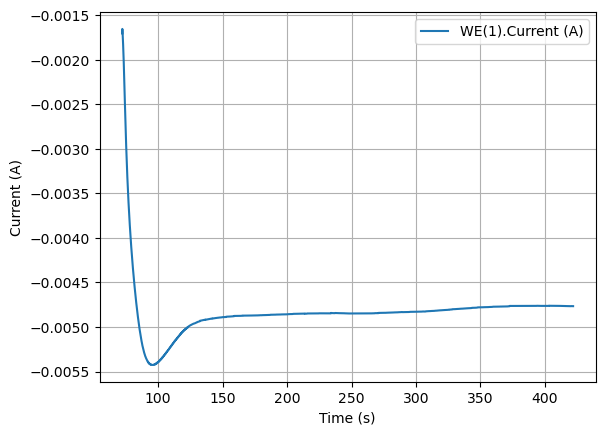

In [13]:
#CA_2 plot
x = "time"
y = "current"
makeplot(x, y,aliases_columns, aliases_axis, current_df)

#potential vs current


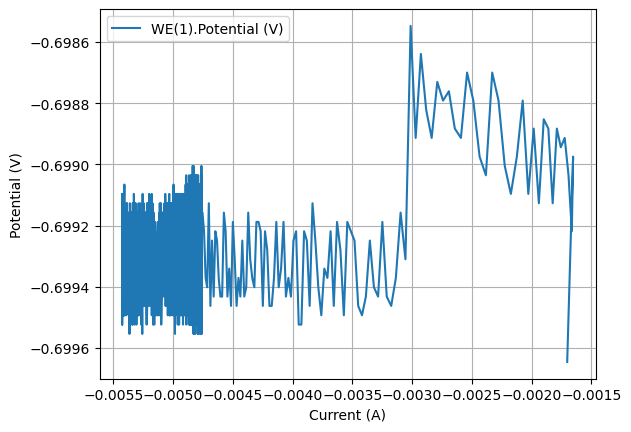

In [14]:
#CA_2 plot
y = "potential"
x = "current"
makeplot(x, y,aliases_columns, aliases_axis, ca_2_df)

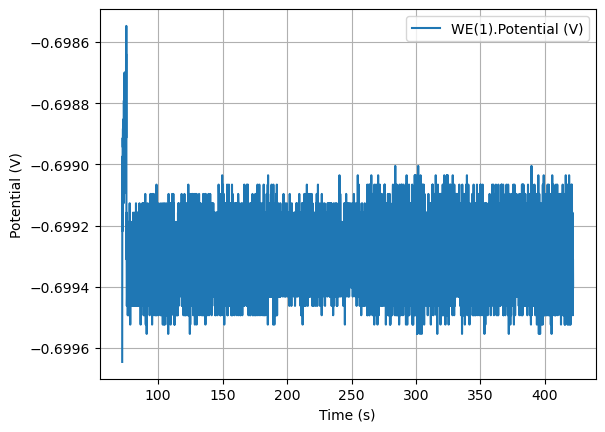

In [15]:
#CA_2 plot
x = "time"
y = "potential"
makeplot(x, y,aliases_columns, aliases_axis, ca_2_df)

In [16]:
##### OCP 3 
ocp_1_df = pd.read_csv(OCP_1_filename, sep = "\t")
ocp_1_df


Time (s)  OCP value (V)
0   10.935907       0.395294
1   11.935907            NaN
2   12.935907            NaN
3   13.935907            NaN
4   14.935907            NaN
5   15.935907            NaN
6   16.935907            NaN
7   17.935907            NaN
8   18.935907            NaN
9   19.935907            NaN
10  20.935907            NaN
11  21.935907            NaN
12  22.935907            NaN
13  23.935907            NaN
14  24.935907            NaN
15  25.935907            NaN
16  26.935907            NaN
17  27.935907            NaN
18  28.935907            NaN
19  29.935907            NaN
20  30.935907            NaN
21  31.935907            NaN
22  32.935907            NaN
23  33.935907            NaN
24  34.935907            NaN
25  35.935907            NaN
26  36.935907            NaN
27  37.935907            NaN
28  38.935907            NaN
29  39.935907            NaN
30  40.935907            NaN
31  41.935907            NaN
32  42.935907            NaN
33  43.935907            NaN
34  44.935907            NaN
35  45.935907            NaN
36  46.935907            NaN
37  47.935907            NaN
38  48.935907            NaN
39  49.935907            NaN
40  50.935907            NaN
41  51.935907            NaN
42  52.935907            NaN
43  53.935907            NaN
44  54.935907            NaN
45  55.935907            NaN
46  56.935907            NaN
47  57.935907            NaN
48  58.935907            NaN
49  59.935907            NaN
50  60.935907            NaN
51  61.935907            NaN
52  62.935907            NaN
53  63.935907            NaN
54  64.935907            NaN
55  65.935907            NaN
56  66.935907            NaN
57  67.935907            NaN
58  68.935907            NaN
59  69.935907            NaN

In [17]:
#### wo3_film_continuous_electrodeposition_B
def wo3_film_continuous_electrodeposition_B_0230619():

    #area cm**2
    ito_area = 2.5*2.5 #cm**2
        
    
    current_folder = os.path.join(base_folder, r"Edgar\20230619\20230619\electrodeposition_WO3_thin_films_onto_ITO_A\wo3_film_continuous_electrodeposition_B" )
    
    CA_2_file = os.path.join(current_folder, "CA_2")
    OCP_1_file =  os.path.join(current_folder, "OCP_1")
    OCP_3_file =  os.path.join(current_folder, "OCP_3")
    
    #column names lists
    column_names_CA = ["time", "current", "voltage"] 
    column_names_OCP = ["time", "voltage"] 

    #column labels
    column_labels_CA = {"time":"Time (s)", "current":"Current (mA/$cm^2$)", "voltage":"Voltage (V)"}
    column_labels_OCP = {"time":"Time (s)", "voltage":"Voltage (V)"}
    
    #read files
    CA_2_df = pd.read_csv(CA_2_file, sep = "\t", names = column_names_CA, header = 0)
    OCP_1_df = pd.read_csv(OCP_1_file, sep = "\t", names = column_names_OCP, header = 0)
    OCP_3_df = pd.read_csv(OCP_3_file, sep = "\t", names = column_names_OCP, header = 0)

    #print dataframes
    print(OCP_1_df)
    print(OCP_3_df)
    
    #calculate current density
    
    CA_2_df["current"] = CA_2_df["current"] / ito_area * 1000 #to change it to mA/cm**2


    #CA_2 plot time vs current
    x = "time"
    y = "current"
    CA_2_df.plot(x, y, grid =True)
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()
    
    #CA_2 plot current vs voltage
    x = "current"
    y = "voltage"
    CA_2_df.plot(x, y, grid =True)
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()


         time   voltage
0    5.534806  0.329102
1    6.534806  0.329407
2    7.534806  0.329681
3    8.534806  0.329987
4    9.534806  0.330261
5   10.534806  0.330536
6   11.534806  0.330841
7   12.534806  0.331085
8   13.534806  0.331390
9   14.534806  0.331665
10  15.534806  0.331848
11  16.534806  0.332184
12  17.534806  0.332489
13  18.534806  0.332703
14  19.534806  0.333038
15  20.534806  0.333374
16  21.534806  0.333679
17  22.534806  0.334015
18  23.534806  0.334320
19  24.534806  0.334625
20  25.534806  0.334930
21  26.534806  0.335205
22  27.534806  0.335510
23  28.534806  0.335815
24  29.534806  0.336121
25  30.534806  0.336395
26  31.534806  0.336578
27  32.534806  0.336945
28  33.534806  0.337250
29  34.534806  0.337524
30  35.534806  0.337799
31  36.534806  0.338074
32  37.534806  0.338348
33  38.534806  0.338623
34  39.534806  0.338898
35  40.534806  0.339203
36  41.534806  0.339447
37  42.534806  0.339722
38  43.534806  0.339966
39  44.534806  0.340240
40  45.534806  0

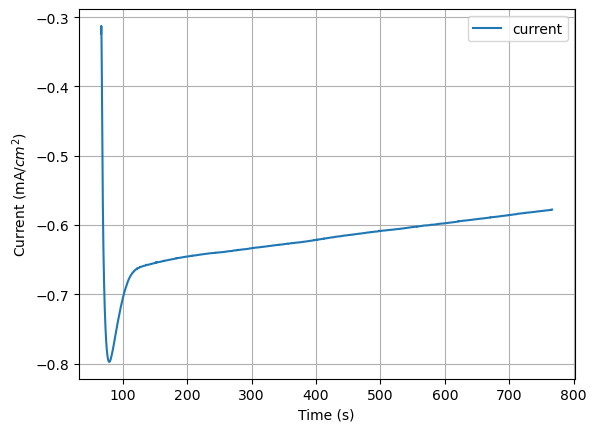

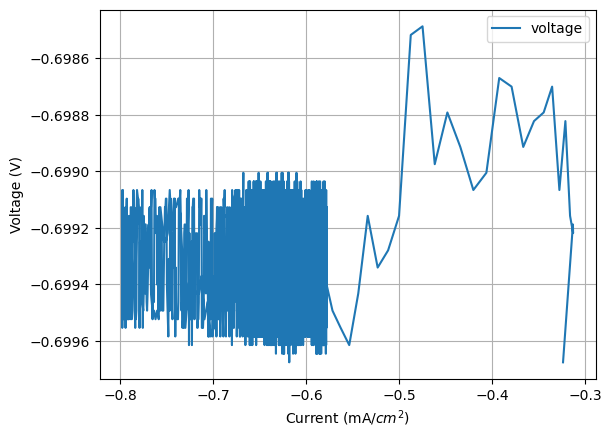

In [18]:
wo3_film_continuous_electrodeposition_B_0230619()

## 20230626

### electrodeposition_prussian_blue

#### electrodeposition_sample_B

In [19]:
def electrodeposition_prussian_blue_electrodeposition_sample_B_20230626():

    #area cm**2
    ito_area = 2.5*2.5 #cm**2
     
    current_folder = os.path.join(base_folder, r"Edgar\20230626\20230626\electrodeposition_prussian_blue\electrodeposition_sample_B")
    
    #CA_2_file = os.path.join(current_folder, "CA_2")
    CP_data_2_file = os.path.join(current_folder, "CP_data_2")
    OCP_1_file =  os.path.join(current_folder, "OCP_1")
    OCP_3_file =  os.path.join(current_folder, "OCP_3")
    
    #column names lists
    column_names_CA = ["time", "voltage", "current"] 
    column_names_OCP = ["time", "voltage"] 

    #column labels
    column_labels_CA = {"time":"Time (s)", "current":"Current (mA/cm^2)", "voltage":"Voltage (V)"}
    column_labels_OCP = {"time":"Time (s)", "voltage":"Voltage (V)"}
    
    #read files
    CP_data_2_df = pd.read_csv(CP_data_2_file, sep = "\t", names = column_names_CA, header = 0)
    OCP_1_df = pd.read_csv(OCP_1_file, sep = "\t", names = column_names_OCP, header = 0)
    OCP_3_df = pd.read_csv(OCP_3_file, sep = "\t", names = column_names_OCP, header = 0)

    #print dataframes
    print(OCP_1_df)
    print(OCP_3_df)
    
    #calculate current density
    
    CP_data_2_df["current"] = CP_data_2_df["current"] / ito_area * 1000 #to change it to mA/cm**2
    #CP_data_2_df["current"] = np.round(CP_data_2_df["current"], 4)

    #CA_2 plot time vs current
    x = "time"
    y = "current"
    CP_data_2_df.plot(x, y, grid =True)
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()
    
    #CA_2 plot current vs voltage
    x = "current"
    y = "voltage"
    CP_data_2_df.plot(x, y, grid =True)
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()


        time   voltage
0  10.985926  1.052856
1  11.085926  1.052856
2  11.185926  1.052856
3  11.285926  1.052856
4  11.385926  1.052856
5  11.485926  1.052856
6  11.585926  1.052856
7  11.685926  1.052856
8  11.785926  1.052856
           time   voltage
0    164.609751  1.325684
1    165.609751  1.292419
2    166.609751  1.274719
3    167.609751  1.262817
4    168.609751  1.254272
..          ...       ...
295  459.609750  1.093750
296  460.609750  1.093750
297  461.609750  1.093750
298  462.609750  1.093445
299  463.609750  1.093445

[300 rows x 2 columns]


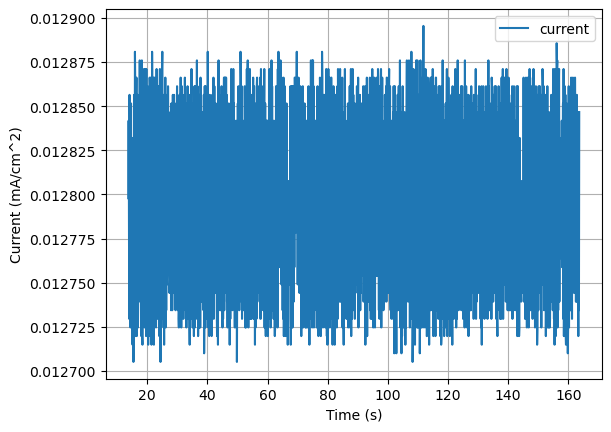

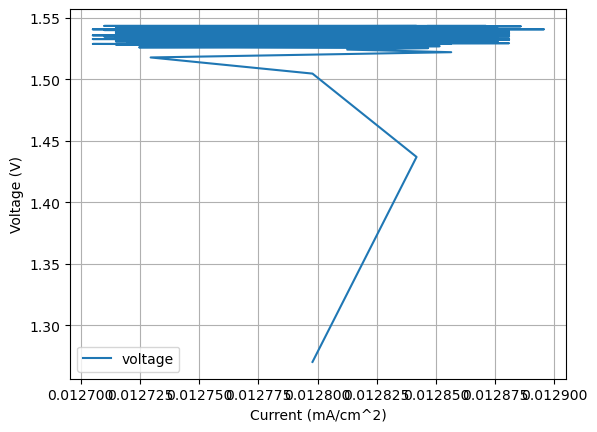

In [20]:
electrodeposition_prussian_blue_electrodeposition_sample_B_20230626()

#### electrodeposition_sample_D

In [21]:
def electrodeposition_prussian_blue_electrodeposition_sample_D_20230626():

    #area cm**2
    ito_area = 2.5*2.5 #cm**2
        
    
    current_folder = os.path.join(base_folder, r"Edgar\20230626\20230626\electrodeposition_prussian_blue\electrodeposition_sample_D")
    #CA_2_file = os.path.join(current_folder, "CA_2")
    CP_data_2_file = os.path.join(current_folder, "CP_data_2")
    OCP_1_file =  os.path.join(current_folder, "OCP_1")
    OCP_3_file =  os.path.join(current_folder, "OCP_3")
    
    #column names lists
    
    column_names_CA = ["time", "voltage", "current"] 
    column_names_OCP = ["time", "voltage"] 

    #column labels
    column_labels_CA = {"time":"Time (s)", "current":"Current (mA/cm^2)", "voltage":"Voltage (V)"}
    column_labels_OCP = {"time":"Time (s)", "voltage":"Voltage (V)"}
    
    #read files
    CP_data_2_df = pd.read_csv(CP_data_2_file, sep = "\t", names = column_names_CA, header = 0)
    OCP_1_df = pd.read_csv(OCP_1_file, sep = "\t", names = column_names_OCP, header = 0)
    OCP_3_df = pd.read_csv(OCP_3_file, sep = "\t", names = column_names_OCP, header = 0)

    #print dataframes
    print(OCP_1_df)
    print(OCP_3_df)
    
    #calculate current density
    
    CP_data_2_df["current"] = CP_data_2_df["current"] / ito_area * 1000 #to change it to mA/cm**2
    #CP_data_2_df["current"] = np.round(CP_data_2_df["current"], 4)

    #CA_2 plot time vs current
    x = "time"
    y = "current"
    CP_data_2_df.plot.scatter(x, y, grid =True)
    plt.title("File CP_data_2")
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()
    
    #CA_2 plot current vs voltage
    x = "current"
    y = "voltage"
    CP_data_2_df.plot.scatter(x, y, grid =True)
    plt.title("File CP_data_2")
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()


          time   voltage
0     9.095882  0.737610
1     9.195882  0.737610
2     9.295882  0.737915
3     9.395882  0.738220
4     9.495882  0.738220
..         ...       ...
595  68.595882  0.788574
596  68.695882  0.788879
597  68.795882  0.788879
598  68.895882  0.788879
599  68.995882  0.788879

[600 rows x 2 columns]
          time   voltage
0   222.193785  0.767517
1   223.193785  0.769958
2   224.193785  0.770264
3   225.193785  0.770874
4   226.193785  0.771179
5   227.193785  0.771179
6   228.193785  0.771484
7   229.193785  0.771790
8   230.193785  0.772095
9   231.193785  0.772095
10  232.193785  0.772400
11  233.193785  0.772705
12  234.193785  0.772705
13  235.193785  0.773010
14  236.193785  0.773010
15  237.193785  0.773315
16  238.193785  0.773315
17  239.193785  0.773315
18  240.193785  0.773621
19  241.193785  0.773621
20  242.193785  0.773926
21  243.193785  0.773926
22  244.193785  0.773926
23  245.193785  0.773926
24  246.193785  0.774231
25  247.193785  0.774231
2

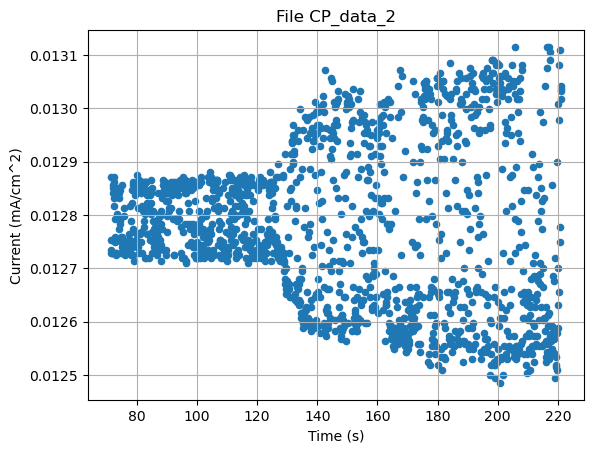

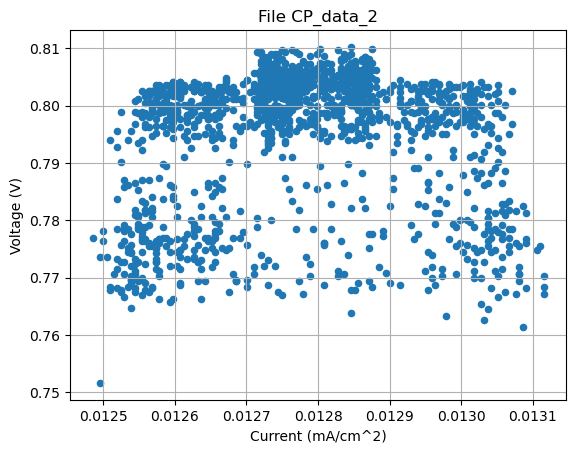

In [22]:
electrodeposition_prussian_blue_electrodeposition_sample_D_20230626()

## 20230810

### WO3_ITO_20230717_G

In [23]:
def WO3_ITO_20230717_G_analysis():

    date = "20230810"
    #area cm**2
    ito_area = 2.5*2.5 #cm**2
        
    
    current_folder = os.path.join(base_folder, r"Edgar\20230810 (1)\WO3_ITO_20230717_G")
    #CA_2_file = os.path.join(current_folder, "CA_2")
    CA_2_file = os.path.join(current_folder, "CA_2")
    OCP_1_file =  os.path.join(current_folder, "OCP_1")
    OCP_3_file =  os.path.join(current_folder, "OCP_3")
    
    #column names lists
    
    column_names_CA = ["time", "voltage", "current"] 
    column_names_OCP = ["time", "voltage"] 

    #column labels
    column_labels_CA = {"time":"Time (s)", "current":"Current (mA/cm^2)", "voltage":"Voltage (V)"}
    column_labels_OCP = {"time":"Time (s)", "voltage":"Voltage (V)"}
    
    #read files
    CA_2_df = pd.read_csv(CA_2_file, sep = "\t", names = column_names_CA, header = 0)
    OCP_1_df = pd.read_csv(OCP_1_file, sep = "\t", names = column_names_OCP, header = 0)
    OCP_3_df = pd.read_csv(OCP_3_file, sep = "\t", names = column_names_OCP, header = 0)

    #print dataframes
    print(OCP_1_df)
    print(OCP_3_df)
    
    #calculate current density
    
    CA_2_df["current"] = CA_2_df["current"] / ito_area * 1000 #to change it to mA/cm**2
    #CP_data_2_df["current"] = np.round(CP_data_2_df["current"], 4)

    #CA_2 plot time vs current
    x = "time"
    y = "current"
    CA_2_df.plot.scatter(x, y, grid =True)
    plt.title(f"File CP_data_2 Date: {date}")
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()
    
    #CA_2 plot current vs voltage
    x = "current"
    y = "voltage"
    CA_2_df.plot.scatter(x, y, grid =True)
    plt.title(f"File CP_data_2. Date: {date}")
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()


        time   voltage
0    3.14623  0.501099
1    4.14623  0.502625
2    5.14623  0.504150
3    6.14623  0.505371
4    7.14623  0.506897
5    8.14623  0.508118
6    9.14623  0.509338
7   10.14623  0.510559
8   11.14623  0.511780
9   12.14623  0.513000
10  13.14623  0.514221
11  14.14623  0.515442
12  15.14623  0.516663
13  16.14623  0.517883
14  17.14623  0.519104
15  18.14623  0.520020
16  19.14623  0.520630
17  20.14623  0.521851
18  21.14623  0.522766
19  22.14623  0.523682
20  23.14623  0.524597
21  24.14623  0.525208
22  25.14623  0.526123
23  26.14623  0.527344
24  27.14623  0.528259
25  28.14623  0.529175
26  29.14623  0.529785
27  30.14623  0.530701
28  31.14623  0.531616
29  32.14623  0.532532
           time   voltage
0    335.324099 -0.583191
1    336.324099 -0.552673
2    337.324099 -0.531311
3    338.324099 -0.513916
4    339.324099 -0.499023
..          ...       ...
415  750.324098  0.166534
416  751.324098  0.166656
417  752.324098  0.166809
418  753.324098  0.166931
4

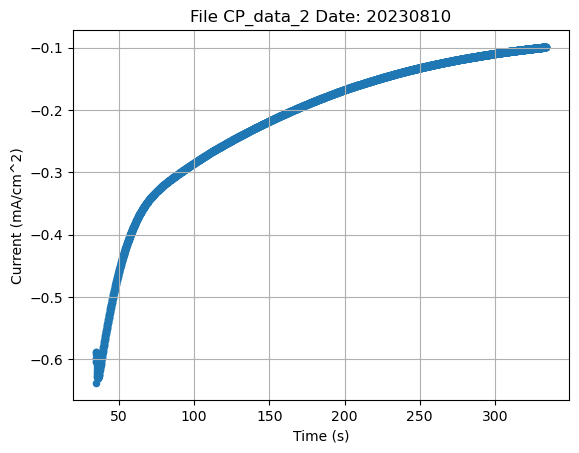

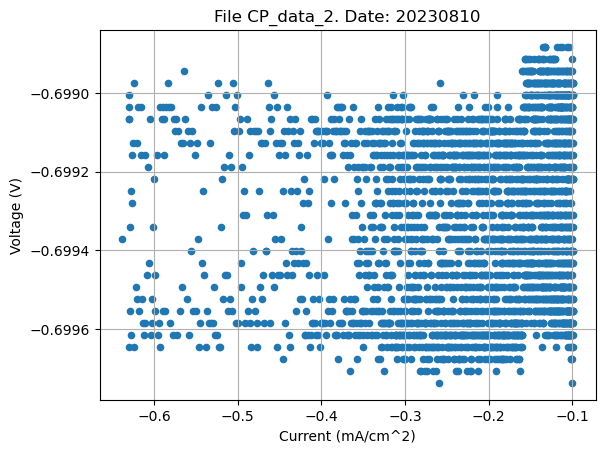

In [24]:
WO3_ITO_20230717_G_analysis()

In [25]:
def WO3_ITO_20230717_H_analysis():
    date = "20230810"
    #area cm**2
    ito_area = 2.5*2.5 #cm**2
      
    current_folder = os.path.join(base_folder, r"Edgar\20230810 (1)\WO3_ITO_20230717_H")
    #CA_2_file = os.path.join(current_folder, "CA_2")
    CA_2_file = os.path.join(current_folder, "CA_2")
    OCP_1_file =  os.path.join(current_folder, "OCP_1")
    OCP_3_file =  os.path.join(current_folder, "OCP_3")
    
    #column names lists
    
    column_names_CA = ["time", "voltage", "current"] 
    column_names_OCP = ["time", "voltage"] 

    #column labels
    column_labels_CA = {"time":"Time (s)", "current":"Current (mA/cm^2)", "voltage":"Voltage (V)"}
    column_labels_OCP = {"time":"Time (s)", "voltage":"Voltage (V)"}
    
    #read files
    CA_2_df = pd.read_csv(CA_2_file, sep = "\t", names = column_names_CA, header = 0)
    OCP_1_df = pd.read_csv(OCP_1_file, sep = "\t", names = column_names_OCP, header = 0)
    OCP_3_df = pd.read_csv(OCP_3_file, sep = "\t", names = column_names_OCP, header = 0)

    #print dataframes
    print(OCP_1_df)
    print(OCP_3_df)
    
    #calculate current density
    
    CA_2_df["current"] = CA_2_df["current"] / ito_area * 1000 #to change it to mA/cm**2
    #CP_data_2_df["current"] = np.round(CP_data_2_df["current"], 4)

    #CA_2 plot time vs current
    x = "time"
    y = "current"
    CA_2_df.plot.scatter(x, y, grid =True)
    plt.title(f"File CP_data_2. Date: {date}")
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()
    
    #CA_2 plot current vs voltage
    x = "voltage"
    y = "current"
    CA_2_df.plot.scatter(x, y, grid =True)
    plt.title(f"File CP_data_2. Date: {date}")
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()

         time   voltage
0    9.563882  0.597229
1   10.563882  0.597229
2   11.563882  0.597229
3   12.563882  0.597229
4   13.563882  0.597534
5   14.563882  0.597534
6   15.563882  0.597534
7   16.563882  0.597534
8   17.563882  0.597229
9   18.563882  0.597229
10  19.563882  0.597229
11  20.563882  0.597229
12  21.563882  0.597229
13  22.563882  0.596924
14  23.563882  0.596619
15  24.563882  0.595398
16  25.563882  0.595398
17  26.563882  0.595093
18  27.563882  0.595093
19  28.563882  0.595093
20  29.563882  0.595093
21  30.563882  0.594788
22  31.563882  0.594788
23  32.563882  0.594482
24  33.563882  0.594482
25  34.563882  0.594482
26  35.563882  0.594482
27  36.563882  0.594177
28  37.563882  0.594177
29  38.563882  0.594177
           time   voltage
0    341.956222 -0.526428
1    342.956222 -0.481720
2    343.956222 -0.448792
3    344.956222 -0.426636
4    345.956222 -0.413727
..          ...       ...
415  756.956221  0.079376
416  757.956221  0.079803
417  758.956221  0.080

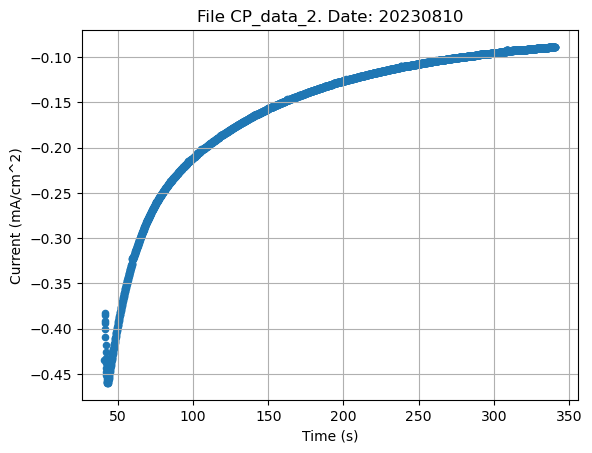

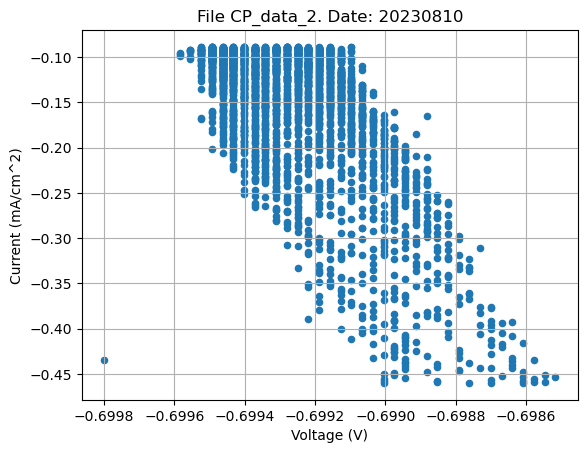

In [26]:
WO3_ITO_20230717_H_analysis()

## 20230821

###  electrochromic_setup_test\test_1_0p5_0p5_OCP

In [27]:
def electrochromic_setup_test_analysis_test_1_0p5_0p5_OCP_20230821():
    date = "20230821"
    #area cm**2
    ito_area = 2.5*2.5 #cm**2
        
    current_folder = os.path.join(base_folder, r"Edgar\20230821\20230821\electrochromic_setup_test\test_1_0p5_0p5_OCP")
    
    
    #CA_2_file = os.path.join(current_folder, "CA_2")
    CV_1_file = os.path.join(current_folder, "CV_1.txt")
    OCP_1_file =  os.path.join(current_folder, "OCP_1.txt")
    #OCP_3_file =  os.path.join(current_folder, "OCP_3")
    
    #column names lists
    
    column_names_CA = ["time", "voltage", "current"] 
    column_names_OCP = ["time", "voltage"] 

    #column labels
    column_labels_CA = {"time":"Time (s)", "current":"Current (mA/cm^2)", "voltage":"Voltage (V)"}
    column_labels_OCP = {"time":"Time (s)", "voltage":"Voltage (V)"}
    
    #read files
    CV_1_df = pd.read_csv(CV_1_file, sep = "\t", names = column_names_CA, header = 0)
    OCP_1_df = pd.read_csv(OCP_1_file, sep = "\t", names = column_names_OCP, header = 0)
    #OCP_3_df = pd.read_csv(OCP_3_file, sep = "\t", names = column_names_OCP, header = 0)

    #print dataframes
    print(CV_1_df)
    print(OCP_1_df)
    
    #calculate current density
    
    CV_1_df["current"] = CV_1_df["current"] / ito_area * 1000 #to change it to mA/cm**2
    #CP_data_2_df["current"] = np.round(CP_data_2_df["current"], 4)

    #CA_2 plot time vs current
    x = "time"
    y = "current"
    CV_1_df.plot.scatter(x, y, grid =True)
    plt.title(f"File test_1_0p5_0p5_OCP/CV_1.txt. Date: {date}")
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()
    
    #CA_2 plot current vs voltage
    x = "voltage"
    y = "current"
    CV_1_df.plot.scatter(x, y, grid =True)
    plt.title(f"File test_1_0p5_0p5_OCP/OCP_1.txt. Date: {date}")
    plt.xlabel(column_labels_CA[x])
    plt.ylabel(column_labels_CA[y])
    plt.show()

           time   voltage       current
0     37.999232  0.170959  2.593994e-08
1     38.096888  0.173492  3.845215e-08
2     38.194544  0.176514  4.577637e-08
3     38.292200  0.178223  5.401611e-08
4     38.389856  0.180695  4.635620e-08
..          ...       ...           ...
815  117.588872  0.158691  2.923584e-07
816  117.686528  0.161346  2.822876e-07
817  117.784184  0.164185  2.795410e-07
818  117.881840  0.166565  2.752686e-07
819  117.979496  0.168884  2.792358e-07

[820 rows x 3 columns]
         time   voltage
0   11.905924  0.168365
1   12.905924  0.168396
2   13.905924  0.168396
3   14.905924  0.168427
4   15.905924  0.168457
5   16.905924  0.168457
6   17.905924  0.168488
7   18.905924  0.168518
8   19.905924  0.168518
9   20.905924  0.168549
10  21.905924  0.168579
11  22.905924  0.168579
12  23.905924  0.168610
13  24.905924  0.168640
14  25.905924  0.168671
15  26.905924  0.168671
16  27.905924  0.168701
17  28.905924  0.168732
18  29.905924  0.168732
19  30.905924  0

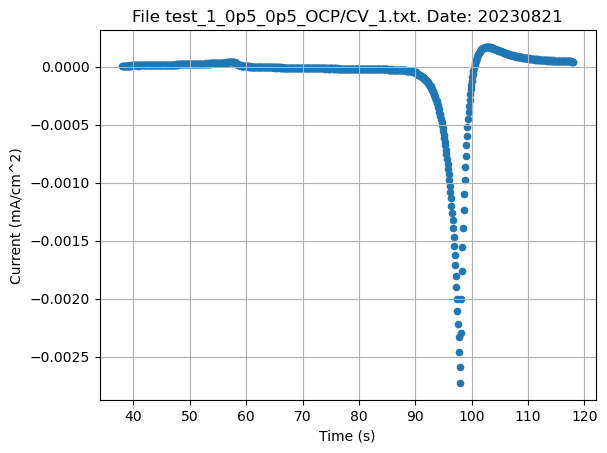

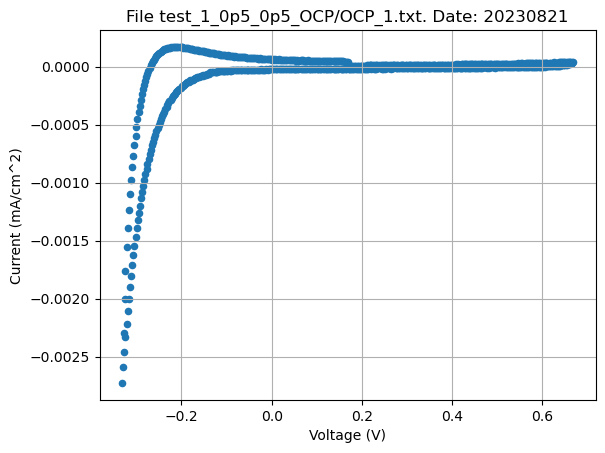

In [28]:
electrochromic_setup_test_analysis_test_1_0p5_0p5_OCP_20230821()

### electrochromic_setup_test\test_2_1_0p5_OCP

In [29]:
def electrochromic_setup_test_analysis_test_2_1_0p5_OCP_20230821():

    import pandas as pd

        
    date = "20230821"
    #area cm**2
    ito_area = 1.2 #cm**2
    
    current_folder = os.path.join(base_folder, r"Edgar\20230821\20230821\electrochromic_setup_test\test_2_1_0p5_OCP")
    
    
    CV_2_file = os.path.join(current_folder, "CV_2.txt")
    CV_2_b_file = os.path.join(current_folder, "CV_2_b.txt")
    OCP_1_file =  os.path.join(current_folder, "OCP_1.txt")
    OCP_1_b_file =  os.path.join(current_folder, "OCP_1_b.txt")
    

    #read files
    CV_2 =  PotentiostatFile(file_path = CV_2_file, type_of_file = "CV", date = date, film_area = ito_area) 
    CV_2_b = PotentiostatFile( file_path = CV_2_b_file, type_of_file = "CV", date = date, film_area = ito_area ) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP", date = date, film_area = ito_area) 
    OCP_1_b = PotentiostatFile( file_path = OCP_1_b_file, type_of_file = "OCP", date = date, film_area = ito_area  ) 

    #print dataframes
    print(CV_2.dataframe)
    print(CV_2_b.dataframe)
    print(OCP_1.dataframe)
    print(OCP_1_b.dataframe)
    
    

    def time_vs_current_analysis(df, filename, date , column_labels):
        #filename
        basename = os.path.basename(filename)
        #CA_2 plot time vs current
        x = "time"
        y = "current"
        df.plot.scatter(x, y, grid =True)
        plt.title(f"File {basename} . Date: {date}")
        plt.xlabel(column_labels[x])
        plt.ylabel(column_labels[y])
        plt.show()

    def voltage_vs_current_analysis(df, filename, date, column_labels):
        #filename
        basename = os.path.basename(filename)
        #CA_2 plot time vs current
        x = "voltage"
        y = "current"
        df.plot.scatter(x, y, grid =True)
        plt.title(f"File {basename}. Date: {date}")
        plt.xlabel(column_labels[x])
        plt.ylabel(column_labels[y])
        plt.show()
        
    #Analysis
    CV_2.time_vs_current_analysis()
    CV_2.voltage_vs_current_analysis()

    CV_2_b.time_vs_current_analysis()
    CV_2_b.voltage_vs_current_analysis()
    
    OCP_1.time_vs_voltage_analysis()
    OCP_1_b.time_vs_voltage_analysis()
    
    
    

['time', 'voltage', 'current']
['time', 'voltage', 'current']
['time', 'voltage']
['time', 'voltage']
            time   voltage   current
0      30.496931  0.028046  0.000025
1      30.619001  0.029990  0.000020
2      30.741071  0.032907  0.000028
3      30.863141  0.034628  0.000037
4      30.985211  0.037787  0.000036
...          ...       ...       ...
1225  180.032681  0.015256  0.004247
1226  180.154751  0.018207  0.004237
1227  180.276821  0.020349  0.004217
1228  180.398891  0.022717  0.004219
1229  180.520961  0.025647  0.004199

[1230 rows x 3 columns]
            time   voltage   current
0     254.256077 -0.425018  0.000652
1     254.378147 -0.421387  0.001144
2     254.500217 -0.419434  0.001451
3     254.622287 -0.418091  0.001667
4     254.744357 -0.414642  0.001845
...          ...       ...       ...
1225  403.791827 -0.436798  0.079142
1226  403.913897 -0.434204  0.079142
1227  404.035967 -0.431641  0.079142
1228  404.158037 -0.429688  0.079168
1229  404.280107 -0.42

<Figure size 1500x600 with 0 Axes>

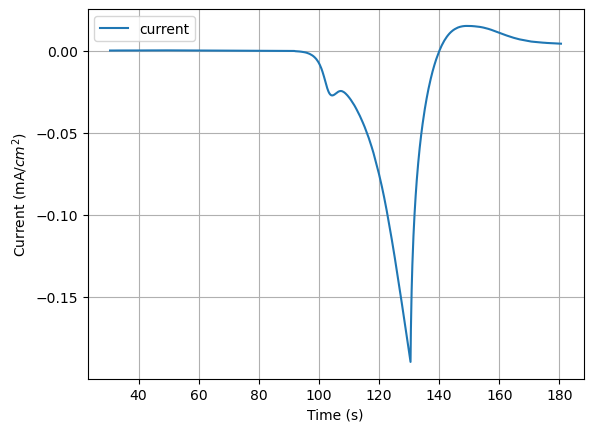

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230821\\20230821\\electrochromic_setup_test\\test_2_1_0p5_OCP\\images'


<Figure size 1500x600 with 0 Axes>

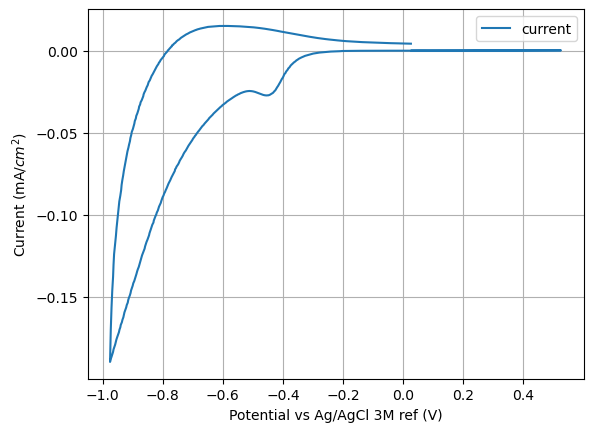

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230821\\20230821\\electrochromic_setup_test\\test_2_1_0p5_OCP\\images'


<Figure size 1500x600 with 0 Axes>

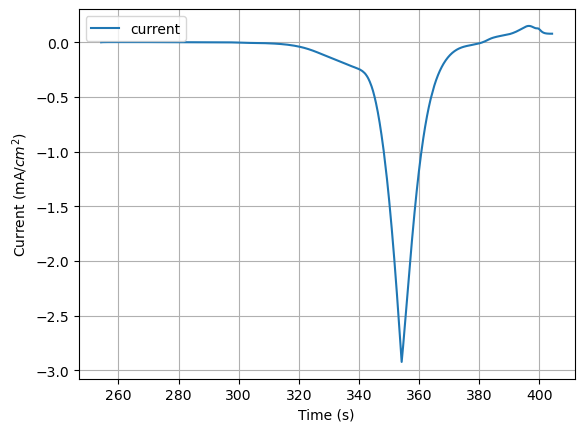

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230821\\20230821\\electrochromic_setup_test\\test_2_1_0p5_OCP\\images'


<Figure size 1500x600 with 0 Axes>

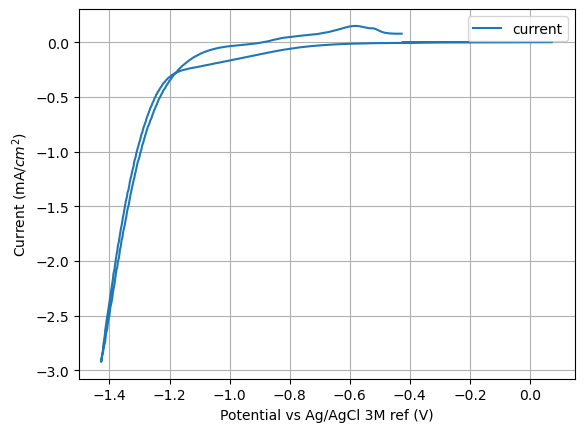

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230821\\20230821\\electrochromic_setup_test\\test_2_1_0p5_OCP\\images'


<Figure size 1500x600 with 0 Axes>

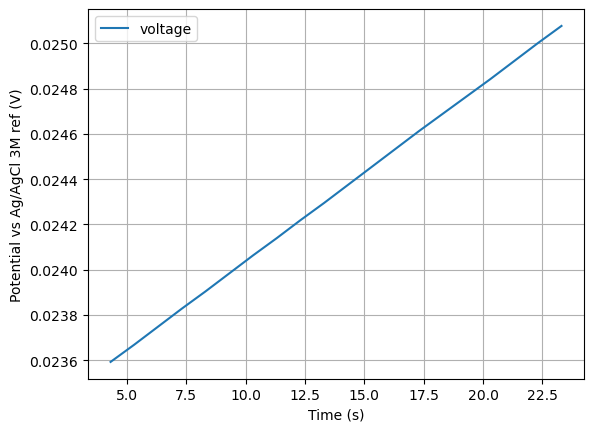

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230821\\20230821\\electrochromic_setup_test\\test_2_1_0p5_OCP\\images'


<Figure size 1500x600 with 0 Axes>

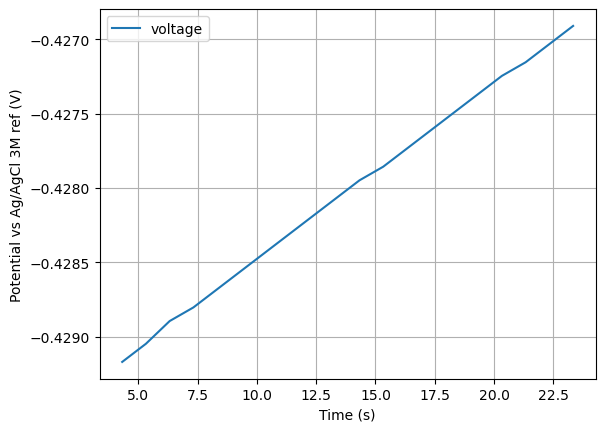

In [30]:
electrochromic_setup_test_analysis_test_2_1_0p5_OCP_20230821()

## 20230906

### EC_measurement_WO3_in_H2SO4_1M_1

In [31]:
## class OpticalFile
class OpticalFile:
        def __init__(self, file_path, date):
            self.file_path = file_path
            #self.type_of_file = type_of_file
            self.column_labels = self._get_column_labels()
            self.column_names = self._get_column_names()
            self.dataframe = self._read_file(file_path, self.column_names)
            self.data_processing()
            self.date = date
            self.start_time = 0
            
        
        def _get_column_labels(self):
           return {"time": "Time","seconds": "Seconds (s)" , "transmittance": "Transmittance %"}
        
                
        def _get_column_names(self):
            names =  ["time", "seconds", "transmittance"]
            return names
        
        def _read_file(self, file_path, column_labels):
            #print(self.column_names)
            return pd.read_csv(file_path, sep='\t|     |    |      ', names=self.column_names, header=8, decimal = ",",engine='python')
            
        def get_filename(self):
            return self.file_path.split('/')[-1]
    
        def time_vs_transmittance(self):
            basename = os.path.basename(self.file_path)
            x = "seconds"
            y = "transmittance"
            df = self.dataframe
            df_filtered = pd.DataFrame([])
            df_filtered = df.loc[df[x]>self.start_time,] 

            #markersizes
            n = len(df_filtered[x].values)  # specify the size of the list
            sizes = [1] * n
            
            #plot
            
            df_filtered.plot.scatter(x, y, grid=True, sizes=sizes)
            plt.title(f"File {basename}. Date: {self.date}")
            plt.ylim(0,100)
            plt.xlabel(self.column_labels[x])
            plt.ylabel(self.column_labels[y])
            plt.show()
            
            
        def get_dataframe(self):
            return self.dataframe
            
        def data_processing(self):
            self.calculate_transmittance()
            
            
        def calculate_transmittance(self):
            #calculate current density
            df = self.dataframe
            max_count = df["transmittance"].max()
            min_count = df["transmittance"].min()
            range = max_count -min_count
            df["transmittance"] = (df["transmittance"] - min_count)  / range * 100 #to change it to mA/cm**2
            
        def calculate_normalized_transmittance(self, start_time):
            self.start_time = start_time
            df = self.dataframe
            max_count_before_start = df.loc[df["seconds"]<start_time, "transmittance"].max()
            max_count_after_start = df.loc[df["seconds"]>start_time ,"transmittance"].max()
            range = max_count_after_start -max_count_before_start
            df["transmittance"] = (df["transmittance"] - max_count_before_start)  / range * 100 #to change it to mA/cm**2

In [32]:
def EC_measurement_WO3_in_H2SO4_1M_1_20230906():
    
    date = "20230906"
    #area cm**2
    ito_area = 2.5*2.5 #cm**2
        
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar\20230906\20230906\EC_measurement_WO3_in_H2SO4_1M_1\electrochromic_data")
    
    
    CV_2_file = os.path.join(electrochromic_data_folder, "CV_2")
    CV_2_b_file = os.path.join(electrochromic_data_folder, "CV_2(1)")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")
    OCP_3_b_file =  os.path.join(electrochromic_data_folder, "OCP_3(1)")
    OCP_reference_optics_file =  os.path.join(electrochromic_data_folder, "OCP_reference_optics")
    
    
    optical_data_folder = os.path.join(base_folder, r"Edgar\20230906\20230906\EC_measurement_WO3_in_H2SO4_1M_1\optical_data")
    
    opt_550nm_1_file = os.path.join(optical_data_folder, "550nm_1.dat")
    opt_550nm_2_file = os.path.join(optical_data_folder, "550nm_2.dat")
    opt_550nm_3_file = os.path.join(optical_data_folder, "550nm_3.dat")
    opt_550nm_4_file = os.path.join(optical_data_folder, "550nm_4.dat")
    opt_850nm_1_file = os.path.join(optical_data_folder, "850nm_1.dat")
    opt_850nm_2_file = os.path.join(optical_data_folder, "850nm_2.dat")
    opt_850nm_3_file = os.path.join(optical_data_folder, "850nm_3.dat")
    opt_850nm_4_file = os.path.join(optical_data_folder, "850nm_4.dat")
    
    #read electrochromic files
    CV_2 =  PotentiostatFile(file_path = CV_2_file, type_of_file = "CV+", date = date, film_area = ito_area) 
    CV_2_b = PotentiostatFile( file_path = CV_2_b_file, type_of_file = "CV+", date = date , film_area = ito_area) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP", date = date , film_area = ito_area) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP", date = date  , film_area = ito_area) 
    OCP_3_b = PotentiostatFile( file_path = OCP_3_b_file, type_of_file = "OCP", date = date  , film_area = ito_area) 
    OCP_reference = PotentiostatFile( file_path = OCP_reference_optics_file, type_of_file = "OCP", date = date  , film_area = ito_area) 

    #optical files 
    opt_550nm_1 =  OpticalFile(file_path = opt_550nm_1_file, date = "20230906") 
    opt_550nm_2 =  OpticalFile(file_path = opt_550nm_2_file, date = "20230906")
    opt_550nm_3 =  OpticalFile(file_path = opt_550nm_3_file, date = "20230906")
    opt_550nm_4 =  OpticalFile(file_path = opt_550nm_4_file, date = "20230906")
    opt_850nm_1 =  OpticalFile(file_path = opt_850nm_1_file, date = "20230906")
    opt_850nm_2 =  OpticalFile(file_path = opt_850nm_2_file, date = "20230906")
    opt_850nm_3 =  OpticalFile(file_path = opt_850nm_3_file, date = "20230906")
    opt_850nm_4 =  OpticalFile(file_path = opt_850nm_4_file, date = "20230906")
   
    #print dataframes
    #print(CV_2.dataframe)
    #print(CV_2_b.dataframe)
    #print(OCP_1.dataframe)
    #print(OCP_3.dataframe)
    #print(OCP_3_b.dataframe)
    #print(OCP_reference.dataframe)
    #print(opt_550nm_1.dataframe)
    #print(opt_550nm_2.dataframe)
    #print(opt_550nm_3.dataframe)
    #print(opt_550nm_4.dataframe)
    #print(opt_850nm_1.dataframe)
    #print(opt_850nm_2.dataframe)
    #print(opt_850nm_3.dataframe)
    #print(opt_850nm_4.dataframe)
    
        
    #Analysis
    CV_2.time_vs_current_analysis()
    CV_2.time_vs_current_analysis(start= 2000, end =2500)
    CV_2.time_vs_current_analysis(start= 8000, end =8500)
    CV_2.time_vs_current_analysis(start= 10000, end =10500)
    CV_2.time_vs_current_analysis(start= 11000, end =11500)
    CV_2.voltage_vs_current_analysis()
    CV_2.voltage_vs_current_analysis(start= 2000, end =2500)
    CV_2.voltage_vs_current_analysis(start= 8000, end =8500)
    CV_2.voltage_vs_current_analysis(start= 10000, end =10500)
    CV_2.voltage_vs_current_analysis(start= 10000, end =11500)

    CV_2_b.time_vs_current_analysis()
    CV_2_b.voltage_vs_current_analysis()
    
    OCP_1.time_vs_voltage_analysis()
    OCP_3_b.time_vs_voltage_analysis()

['time', 'scan', 'voltage', 'current', 'transmittance', 'Q+', 'Q-']
No max and min transmittance info provided
self.max_transmittance=3.11370849609375self.min_transmittance=0.732666015625transmittance_range=2.38104248046875
['time', 'scan', 'voltage', 'current', 'transmittance', 'Q+', 'Q-']
No max and min transmittance info provided
self.max_transmittance=3.1658935546875self.min_transmittance=0.5755615234375transmittance_range=2.59033203125
['time', 'voltage']
['time', 'voltage']
['time', 'voltage']
['time', 'voltage']
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

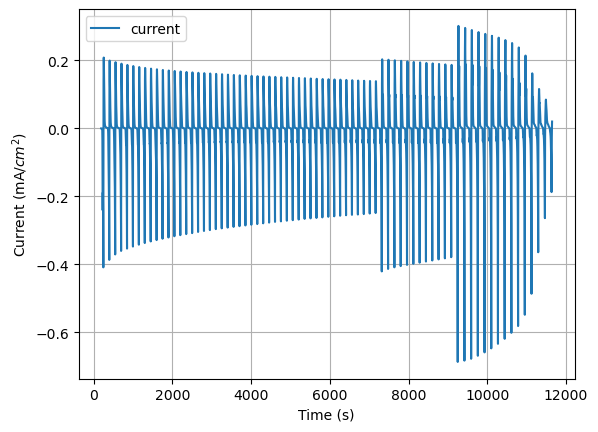

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

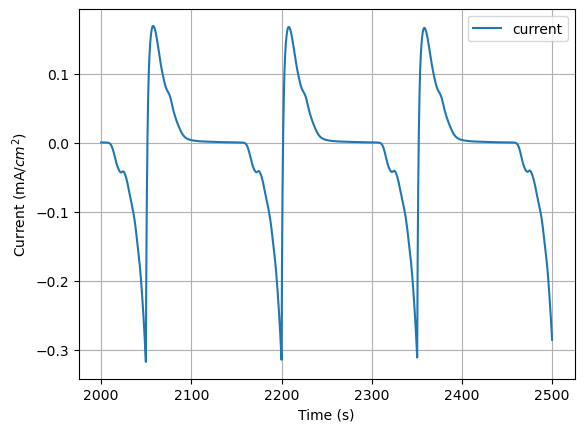

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

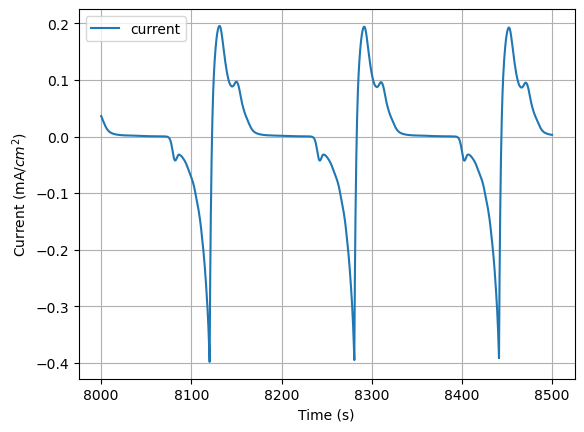

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

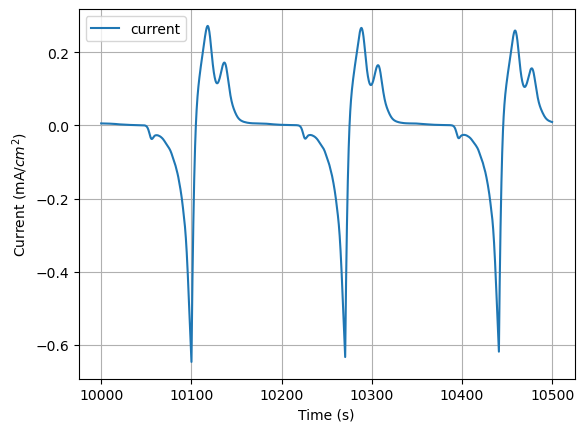

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

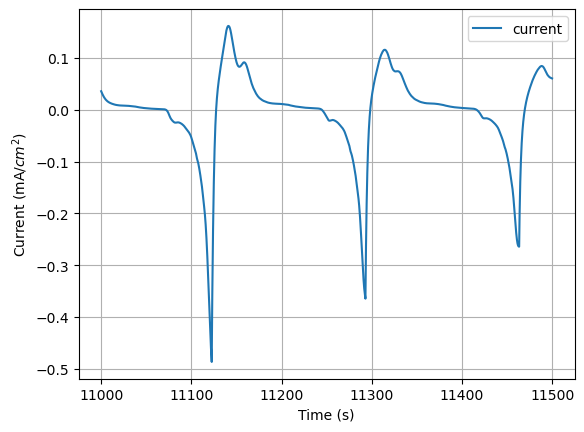

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

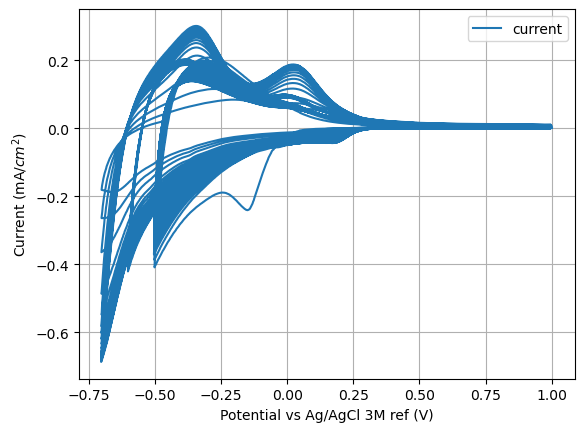

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

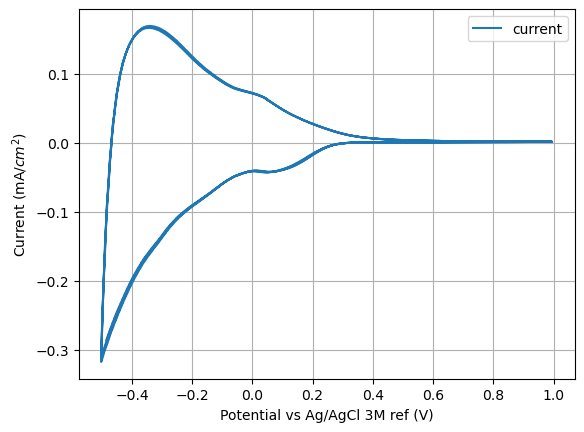

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

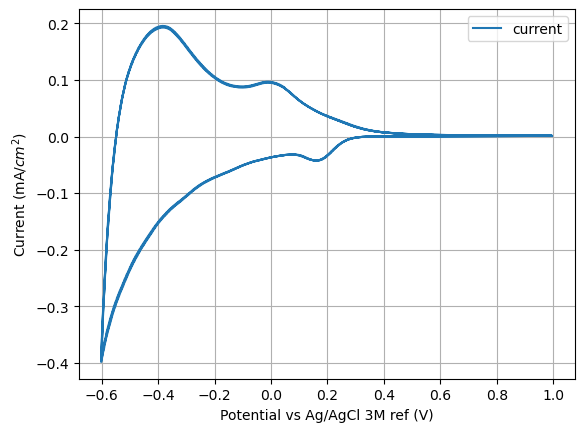

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

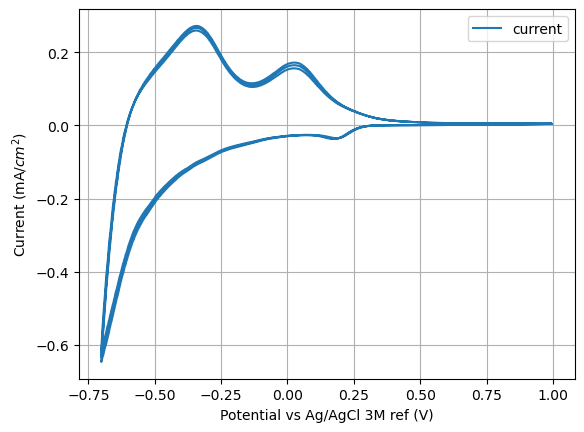

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

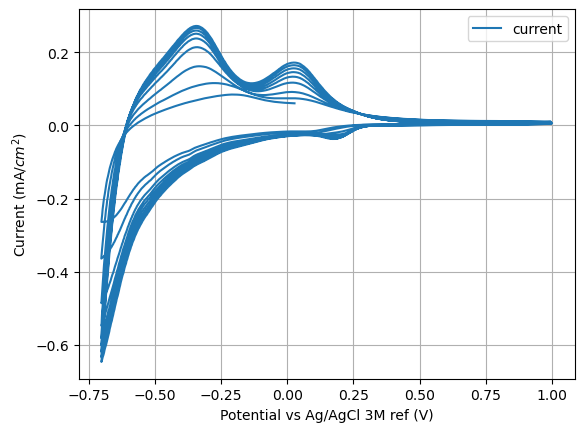

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

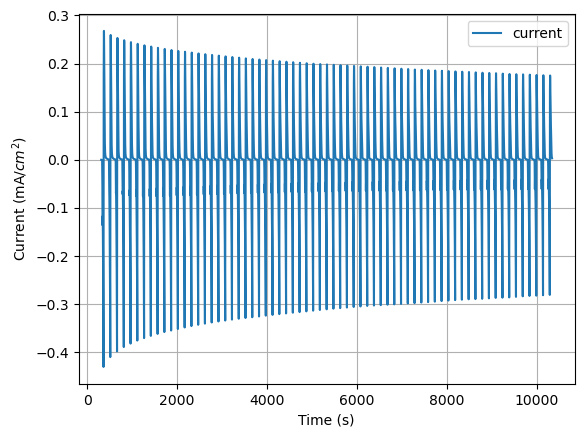

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

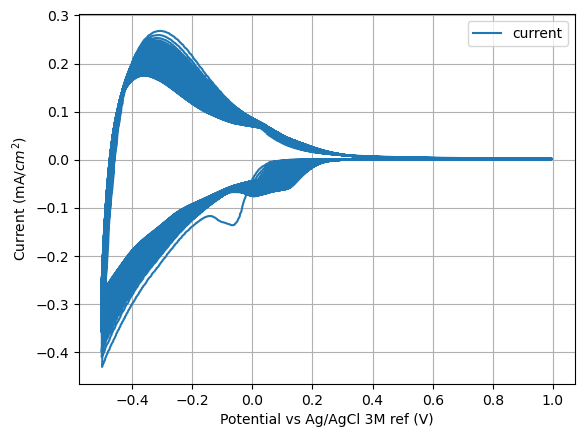

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

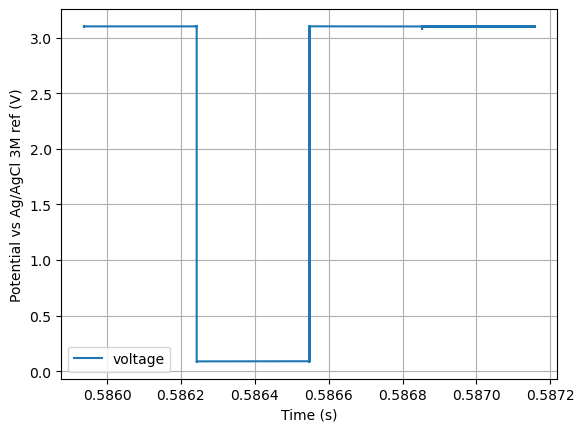

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230906\\20230906\\EC_measurement_WO3_in_H2SO4_1M_1\\electrochromic_data\\images'


<Figure size 1500x600 with 0 Axes>

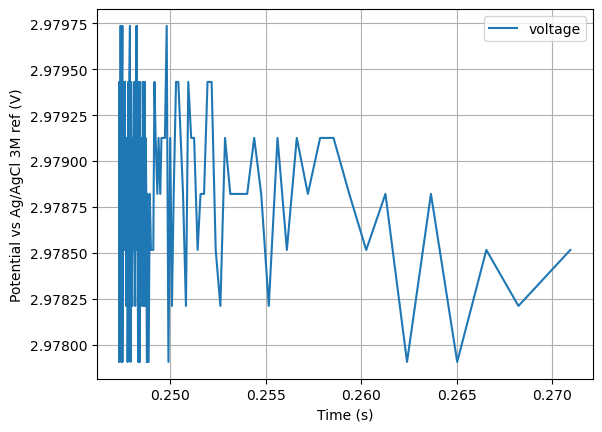

In [33]:
EC_measurement_WO3_in_H2SO4_1M_1_20230906()

## 20230907

### wo3_film_continuous_electrodeposition_A

In [34]:
def wo3_film_continuous_electrodeposition_A_20230907():
    
    date = "20230907"
    #area cm**2
    ito_area = 2.5*2.5 #cm**2
    electrochromic_data_folder = os.path.join(base_folder, "Edgar","20230907","20230907","electrodeposition_WO3_thin_films_onto_ITO_A","wo3_film_continuous_electrodeposition_A")    
    
    
    #CV_2_file = os.path.join(electrochromic_data_folder, "CV_2.txt")
    CA_2_file = os.path.join(electrochromic_data_folder, "CA_2")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")

    #optical_data_folder = r"C:\Users\esteb\electrochromicfilms\Edgar\20230906\20230906\EC_measurement_WO3_in_H2SO4_1M_1\optical_data"

    
    #read files
    CA_2 =  PotentiostatFile(file_path = CA_2_file, type_of_file = "CA", date = date, film_area = ito_area) 
    #CV_2_b = PotentiostatFile( file_path = CV_2_b_file, type_of_file = "CV", date = date ) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP", date = date , film_area = ito_area) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP", date = date , film_area = ito_area ) 

    #print dataframes
    print(CA_2.dataframe)
    #print(CV_2_b.dataframe)
    print(OCP_1.dataframe)
    print(OCP_3.dataframe)
    
    
    #Analysis
    CA_2.time_vs_current_analysis()
    CA_2.voltage_vs_current_analysis()
    
    OCP_1.time_vs_voltage_analysis()
    OCP_3.time_vs_voltage_analysis()

['time', 'voltage', 'current']
['time', 'voltage']
['time', 'voltage']
            time   voltage   current
0      19.910790 -0.699585 -0.745752
1      20.010790 -0.699463 -0.770312
2      20.110790 -0.699524 -0.762793
3      20.210790 -0.699768 -0.765430
4      20.310790 -0.699432 -0.768506
...          ...       ...       ...
5995  619.410788 -0.699768 -0.053730
5996  619.510788 -0.699738 -0.053750
5997  619.610788 -0.699341 -0.053730
5998  619.710788 -0.698944 -0.053735
5999  619.810788 -0.699860 -0.053755

[6000 rows x 3 columns]
               time   voltage
2.743758   0.629272  0.629578
3.743758   0.629272       NaN
4.743758   0.629272       NaN
5.743758   0.629272       NaN
6.743758   0.629272       NaN
7.743758   0.629272       NaN
8.743758   0.629272       NaN
9.743758   0.629272       NaN
10.743758  0.629578       NaN
11.743758  0.629578       NaN
12.743758  0.629578       NaN
13.743758  0.629578       NaN
14.743758  0.629578       NaN
15.743758  0.629578       NaN
16.743758 

<Figure size 1500x600 with 0 Axes>

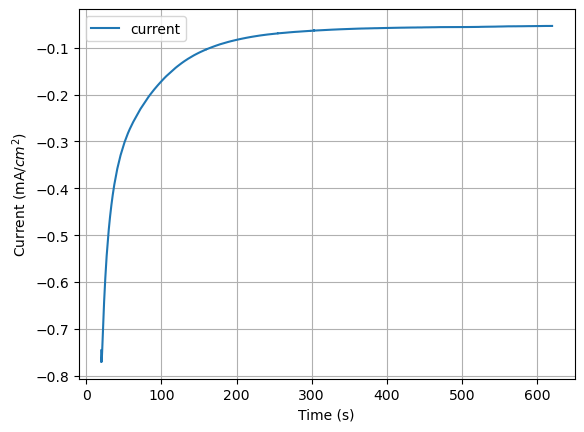

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230907\\20230907\\electrodeposition_WO3_thin_films_onto_ITO_A\\wo3_film_continuous_electrodeposition_A\\images'


<Figure size 1500x600 with 0 Axes>

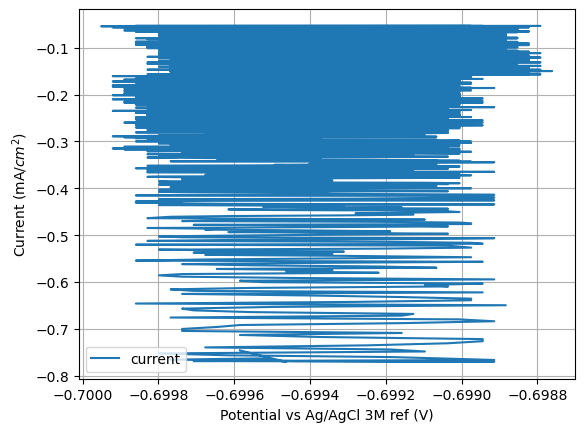

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230907\\20230907\\electrodeposition_WO3_thin_films_onto_ITO_A\\wo3_film_continuous_electrodeposition_A\\images'


<Figure size 1500x600 with 0 Axes>

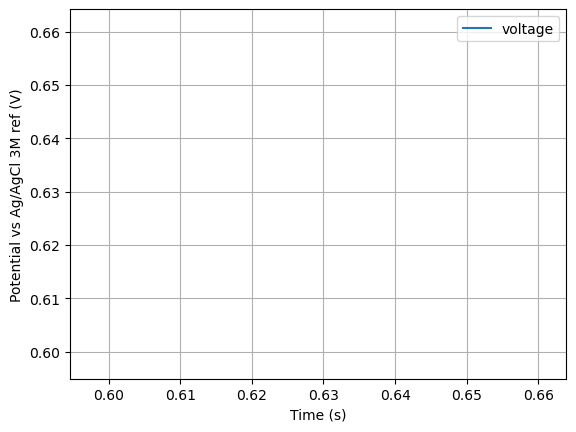

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230907\\20230907\\electrodeposition_WO3_thin_films_onto_ITO_A\\wo3_film_continuous_electrodeposition_A\\images'


<Figure size 1500x600 with 0 Axes>

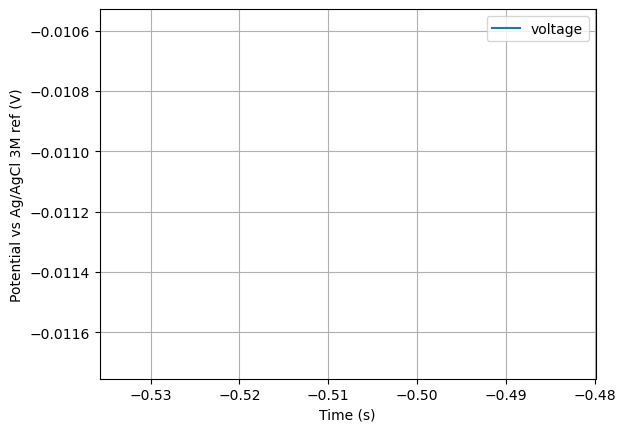

In [35]:
wo3_film_continuous_electrodeposition_A_20230907()

In [36]:
### wo3_film_continuous_electrodeposition_B

def wo3_film_continuous_electrodeposition_B_20230907():
    
    date = "20230907"
    #area cm**2
    ito_area = 2.5*2.5 #cm**2
        
    electrochromic_data_folder = os.path.join(base_folder,r"Edgar","20230907","20230907","electrodeposition_WO3_thin_films_onto_ITO_A","wo3_film_continuous_electrodeposition_B" )
    
    
    #CV_2_file = os.path.join(electrochromic_data_folder, "CV_2.txt")
    CA_2_file = os.path.join(electrochromic_data_folder, "CA_2")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")

    #optical_data_folder = r"C:\Users\esteb\electrochromicfilms\Edgar\20230906\20230906\EC_measurement_WO3_in_H2SO4_1M_1\optical_data"

    
    #read files
    CA_2 =  PotentiostatFile(file_path = CA_2_file, type_of_file = "CA", date = date, film_area = ito_area) 
    #CV_2_b = PotentiostatFile( file_path = CV_2_b_file, type_of_file = "CV", date = date ) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP", date = date , film_area = ito_area) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP", date = date  , film_area = ito_area) 

    #print dataframes
    print(CA_2.dataframe)
    #print(CV_2_b.dataframe)
    print(OCP_1.dataframe)
    print(OCP_3.dataframe)
    
    
    #Analysis
    CA_2.time_vs_current_analysis()
    CA_2.voltage_vs_current_analysis()
    CA_2.voltage_and_current_vs_time_analysis(ylim1 = (-0.8, 0))
    
    OCP_1.time_vs_voltage_analysis()
    OCP_3.time_vs_voltage_analysis()

['time', 'voltage', 'current']
['time', 'voltage']
['time', 'voltage']
            time   voltage   current
0      33.447059 -0.699921 -0.772119
1      33.547059 -0.699280 -0.836914
2      33.647059 -0.699036 -0.829590
3      33.747059 -0.699249 -0.831543
4      33.847059 -0.699707 -0.833496
...          ...       ...       ...
5995  632.947057 -0.699738 -0.061055
5996  633.047057 -0.699036 -0.061025
5997  633.147057 -0.699249 -0.061055
5998  633.247057 -0.699707 -0.061025
5999  633.347057 -0.699829 -0.061045

[6000 rows x 3 columns]
               time   voltage
2.505236   0.265656  0.251495
3.505236   0.265167       NaN
4.505236   0.264679       NaN
5.505236   0.253754       NaN
6.505236   0.245331       NaN
7.505236   0.241180       NaN
8.505236   0.239471       NaN
9.505236   0.239075       NaN
10.505236  0.239471       NaN
11.505236  0.240234       NaN
12.505236  0.241180       NaN
13.505236  0.242218       NaN
14.505236  0.243286       NaN
15.505236  0.244354       NaN
16.505236 

<Figure size 1500x600 with 0 Axes>

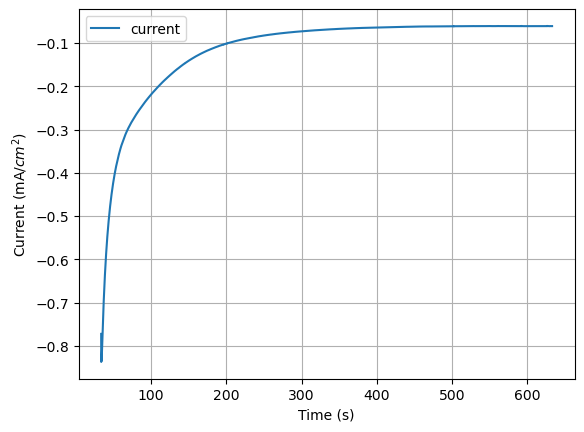

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230907\\20230907\\electrodeposition_WO3_thin_films_onto_ITO_A\\wo3_film_continuous_electrodeposition_B\\images'


<Figure size 1500x600 with 0 Axes>

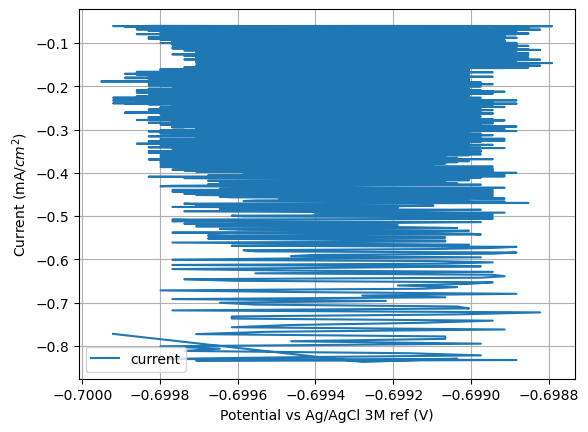

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230907\\20230907\\electrodeposition_WO3_thin_films_onto_ITO_A\\wo3_film_continuous_electrodeposition_B\\images'


<Figure size 1500x600 with 0 Axes>

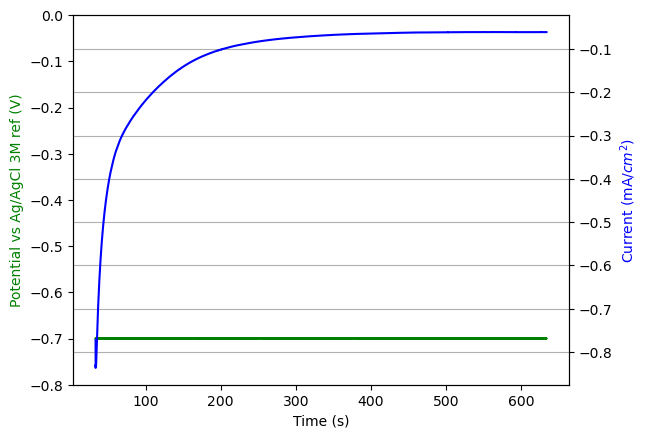

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230907\\20230907\\electrodeposition_WO3_thin_films_onto_ITO_A\\wo3_film_continuous_electrodeposition_B\\images'


<Figure size 1500x600 with 0 Axes>

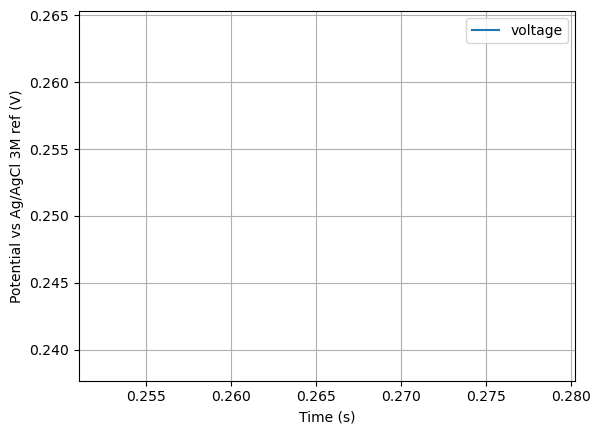

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20230907\\20230907\\electrodeposition_WO3_thin_films_onto_ITO_A\\wo3_film_continuous_electrodeposition_B\\images'


<Figure size 1500x600 with 0 Axes>

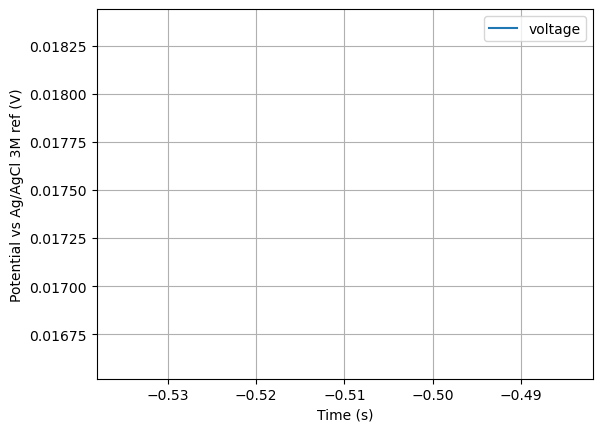

In [37]:
wo3_film_continuous_electrodeposition_B_20230907()

## 20230913
It only has a blank optical file

In [38]:
def test_spectrometer_20230913():
    
    date = "20230913"
    #area cm**2
    ito_area = 2.5*2.5 #cm**2
        

    electrochromic_data_folder = os.path.join(base_folder,r"Edgar\20230913\20230913" )
    optical_1_file = os.path.join(optical_data_folder, "550nm.dat")
    
    #read files
    
    #
    #print dataframes
    print(CA_2.dataframe)
    #print(CV_2_b.dataframe)
    print(OCP_1.dataframe)
    print(OCP_3.dataframe)
    
    
    #Analysis
    CA_2.time_vs_current_analysis()
    CA_2.voltage_vs_current_analysis()
    
    OCP_1.time_vs_voltage_analysis()
    OCP_3.time_vs_voltage_analysis()

## 20240417

### Electrodeposition pulse potential A
No data

### Electrodeposition pulsed potential B

In [39]:
def electrodeposition_pulsed_potential_B_20240417():
    
    date = "20240417"
    #area cm**2
    ito_area = 1.2*1 #cm**2
        
    electrochromic_data_folder = os.path.join(base_folder,r"Edgar","20240417","20240417","electrodeposition_pulsed_potential_B","data" )

    pulses_0_to_1000_file = os.path.join(electrochromic_data_folder, "pulses_0_to_1000.txt")
    pulses_1000_to_2000_file = os.path.join(electrochromic_data_folder, "pulses_1000_to_2000.txt")
    pulses_2000_to_3000_file = os.path.join(electrochromic_data_folder, "pulses_2000_to_3000.txt")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")
    
    #optical_data_folder = r"C:\Users\esteb\electrochromicfilms\Edgar\20230913\20230913"
    #optical_1_file = os.path.join(optical_data_folder, "550nm.dat")
    
    #read files
    
    pulses_0_to_1000 =  PotentiostatFile(file_path = pulses_0_to_1000_file, type_of_file = "CA", date = date, film_area = ito_area )
    pulses_1000_to_2000 =  PotentiostatFile(file_path = pulses_1000_to_2000_file, type_of_file = "CA", date = date, film_area = ito_area) 
    pulses_2000_to_3000 =  PotentiostatFile(file_path = pulses_2000_to_3000_file, type_of_file = "CA", date = date, film_area = ito_area) 
    
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP", date = date, film_area = ito_area ) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP", date = date , film_area = ito_area ) 
    
    #print dataframes
    #print(pulses_0_to_1000.dataframe)
    #print(pulses_1000_to_2000.dataframe)
    #print(pulses_2000_to_3000.dataframe)
    #print(OCP_1.dataframe)
    #print(OCP_3.dataframe)
    
    
    #Analysis
    OCP_1.time_vs_voltage_analysis(ylim = (0, 1.0))
    
    pulses_0_to_1000.time_vs_current_analysis(start = 100, end=200)
    pulses_0_to_1000.voltage_vs_current_analysis(start = 100, end=200)
    pulses_0_to_1000.time_vs_voltage_analysis(start = 100, end=200)
    pulses_0_to_1000.voltage_and_current_vs_time_analysis(start = 180, end=185, ylim1 = (-1, 1))
    
    pulses_1000_to_2000.time_vs_current_analysis(start = 1700, end=1730)
    pulses_1000_to_2000.voltage_vs_current_analysis(start = 1700, end=1730)

    pulses_2000_to_3000.time_vs_current_analysis(start = 3000, end=3030)
    pulses_2000_to_3000.voltage_vs_current_analysis(start = 3000, end=3030)
    
    OCP_3.time_vs_voltage_analysis()

['time', 'voltage', 'current']
['time', 'voltage', 'current']
['time', 'voltage', 'current']
['time', 'voltage']
['time', 'voltage']
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

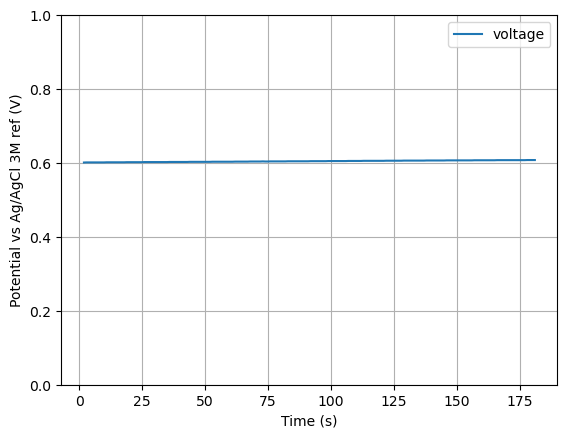

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

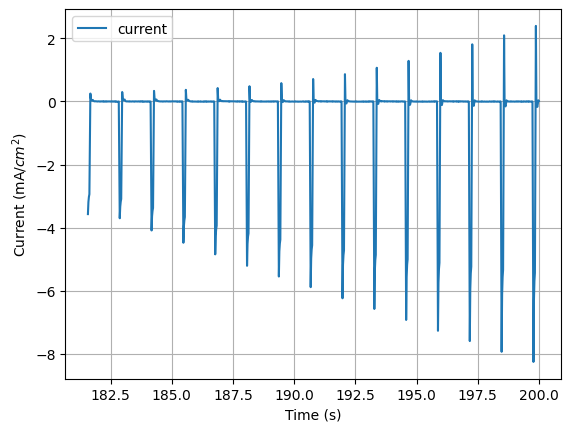

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

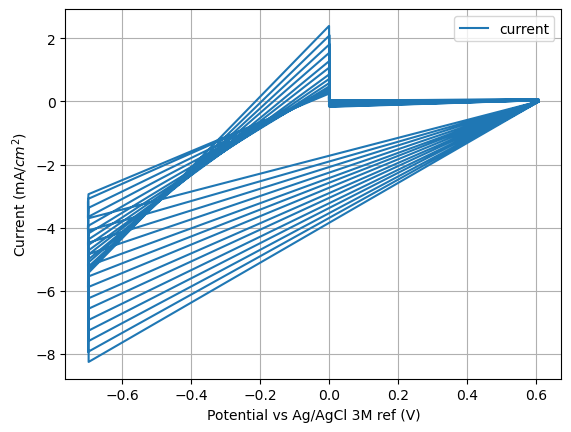

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

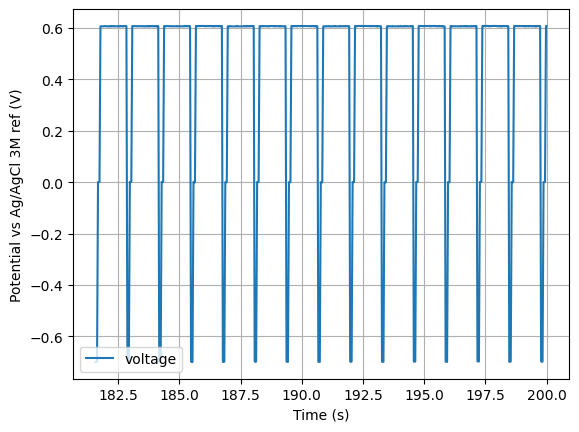

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

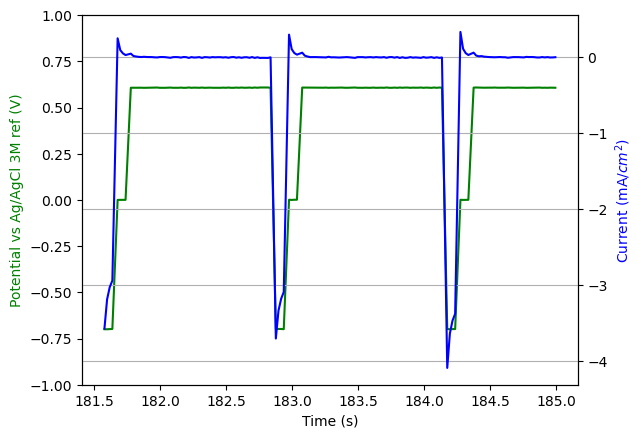

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

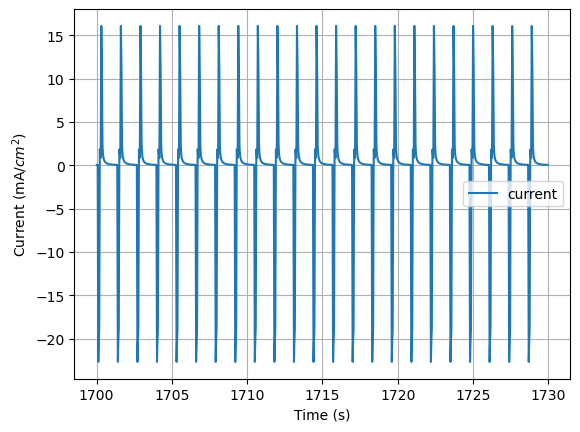

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

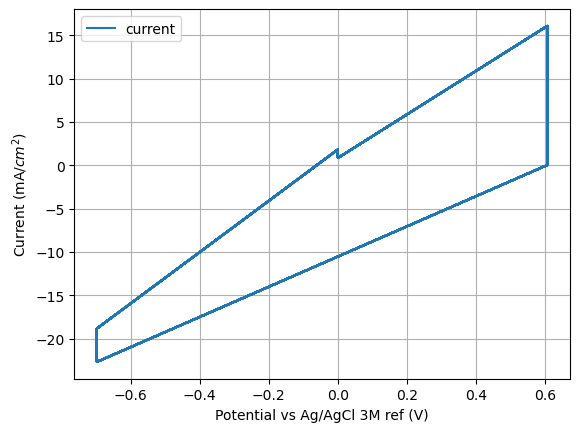

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

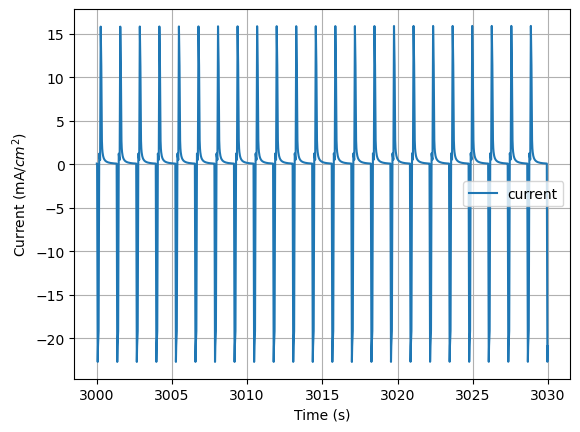

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

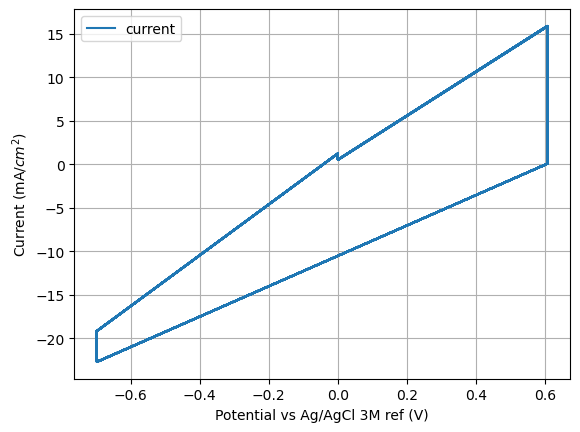

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240417\\20240417\\electrodeposition_pulsed_potential_B\\data\\images'


<Figure size 1500x600 with 0 Axes>

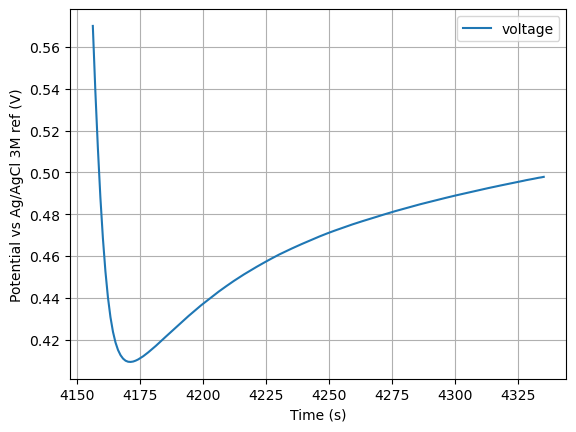

In [40]:
electrodeposition_pulsed_potential_B_20240417()

In [41]:
## 20240424

### chronoamperommetry steps

def chronoamperommetry_steps_A_20240424():
    
    date = "20240424"
    #area cm**2
    ito_area = 1.2*1 #cm**2
        
    electrochromic_data_folder = os.path.join(base_folder,"Edgar","20240424","20240424","chronoamperommetry_steps","A") 
    
    chronoamperommetry_steps_file = os.path.join(electrochromic_data_folder, "Chronoamperommetry_steps.txt")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")
    
    #optical_data_folder = r"C:\Users\esteb\electrochromicfilms\Edgar\20230913\20230913"
    #optical_1_file = os.path.join(optical_data_folder, "550nm.dat")
    
    #read files
    
    chronoamperommetry_steps =  PotentiostatFile(file_path = chronoamperommetry_steps_file, type_of_file = "CA+", date = date, film_area = ito_area) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP", date = date, film_area = ito_area ) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP", date = date, film_area = ito_area  ) 
    
    #print dataframes
    
    #print(chronoamperommetry_steps.dataframe)
    #print(OCP_1.dataframe)
    #print(OCP_3.dataframe)
    
    
    #Analysis
    OCP_1.time_vs_voltage_analysis()
    
    #chronoamperommetry_steps.time_vs_current_analysis()
    chronoamperommetry_steps.voltage_vs_current_analysis()
    #chronoamperommetry_steps.time_vs_voltage_analysis()
    chronoamperommetry_steps.current_and_transmittance_vs_time_analysis()
    #chronoamperommetry_steps.custom_analysis(x = "time", y= "transmittance")
    
    OCP_3.time_vs_voltage_analysis()

['time', 'voltage', 'current', 'transmittance']
No max and min transmittance info provided
self.max_transmittance=2.8741455078125self.min_transmittance=0.380401611328125transmittance_range=2.493743896484375
['time', 'voltage']
['time', 'voltage']
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\A\\images'


<Figure size 1500x600 with 0 Axes>

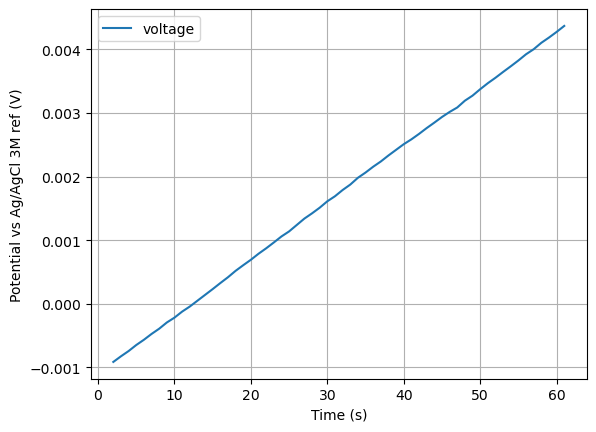

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\A\\images'


<Figure size 1500x600 with 0 Axes>

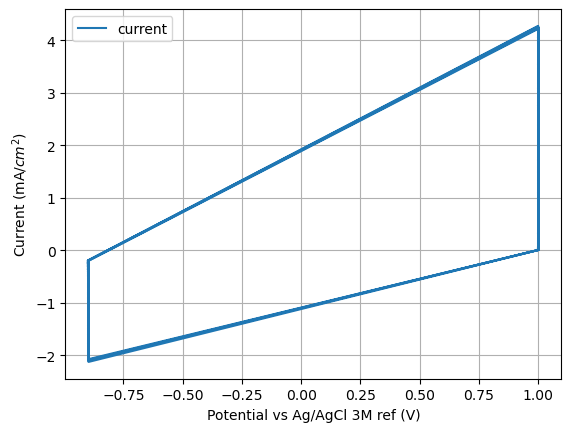

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\A\\images'


<Figure size 1500x600 with 0 Axes>

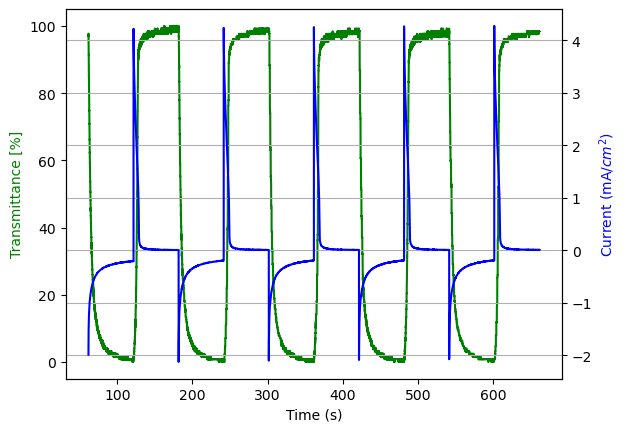

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\A\\images'


<Figure size 1500x600 with 0 Axes>

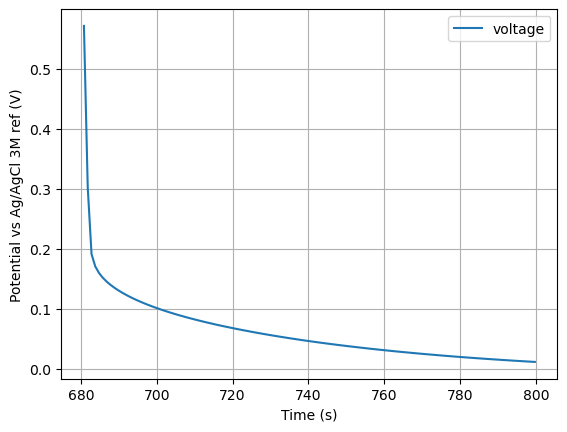

In [42]:
chronoamperommetry_steps_A_20240424()

In [43]:
## 20240424

### chronoamperommetry steps

def chronoamperommetry_steps_B_20240424():
    
    date = "20240424"
    #area cm**2
    ito_area = 1.2*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240424","20240424","chronoamperommetry_steps","B")
    
    
    chronoamperommetry_steps_file = os.path.join(electrochromic_data_folder, "Chronoamperommetry_steps.txt")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")
    
    #optical_data_folder = r"C:\Users\esteb\electrochromicfilms\Edgar\20230913\20230913"
    #optical_1_file = os.path.join(optical_data_folder, "550nm.dat")
    
    #read files
    
    
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP", date = date, film_area = ito_area ) 
    chronoamperommetry_steps =  PotentiostatFile(file_path = chronoamperommetry_steps_file, type_of_file = "CA+", date = date, film_area = ito_area) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP", date = date, film_area = ito_area  ) 
    
    #print dataframes
    
    #print(chronoamperommetry_steps.dataframe)
    #print(OCP_1.dataframe)
    #print(OCP_3.dataframe)
    
    
    #Analysis
    OCP_1.time_vs_voltage_analysis()
    
    #chronoamperommetry_steps.time_vs_current_analysis()
    chronoamperommetry_steps.voltage_vs_current_analysis()
    chronoamperommetry_steps.voltage_and_current_vs_time_analysis()
    #chronoamperommetry_steps.time_vs_voltage_analysis()
    chronoamperommetry_steps.current_and_transmittance_vs_time_analysis()
    #chronoamperommetry_steps.custom_analysis(x = "time", y= "transmittance")
    
    OCP_3.time_vs_voltage_analysis()

['time', 'voltage']
['time', 'voltage', 'current', 'transmittance']
No max and min transmittance info provided
self.max_transmittance=3.1689453125self.min_transmittance=0.713531494140625transmittance_range=2.455413818359375
['time', 'voltage']
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\B\\images'


<Figure size 1500x600 with 0 Axes>

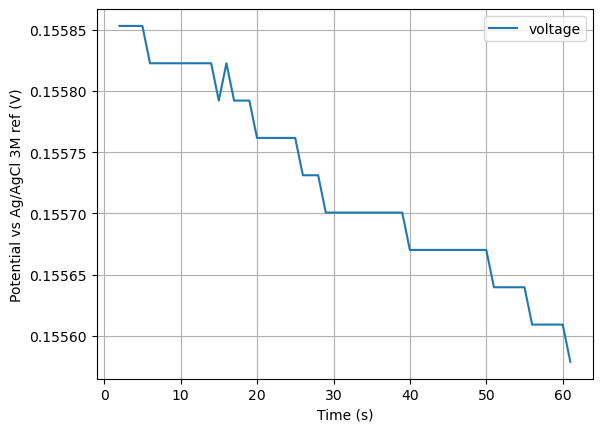

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\B\\images'


<Figure size 1500x600 with 0 Axes>

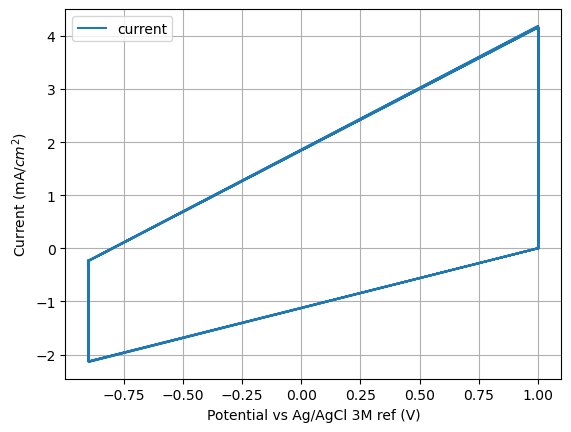

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\B\\images'


<Figure size 1500x600 with 0 Axes>

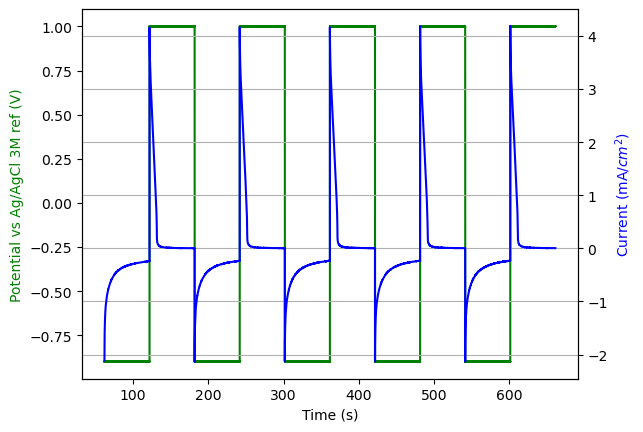

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\B\\images'


<Figure size 1500x600 with 0 Axes>

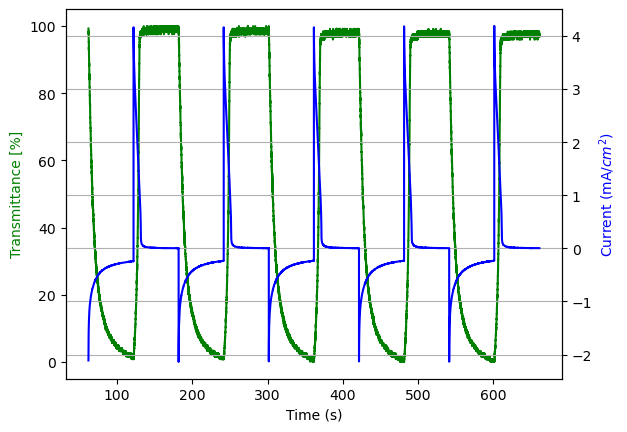

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\chronoamperommetry_steps\\B\\images'


<Figure size 1500x600 with 0 Axes>

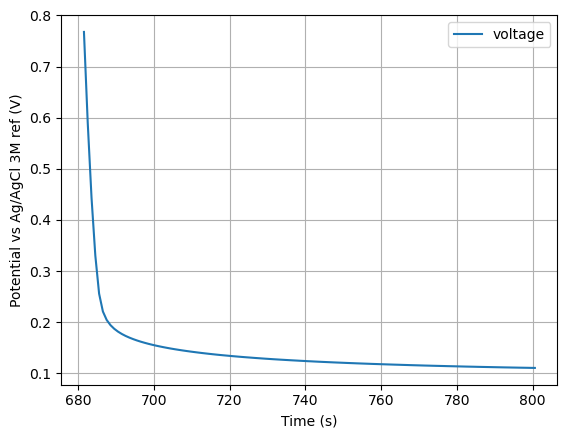

In [44]:
chronoamperommetry_steps_B_20240424()

In [45]:
def cv_analysis(OCP_0_file, OCP_1_file, CV_2_file, OCP_3_file, date, film_area):
    
    #read ocp info 
    OCP_0 = PotentiostatFile( file_path = OCP_0_file, type_of_file = "OCP+", date = date, film_area = film_area ) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP+", date = date, film_area = film_area ) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP+", date = date, film_area = film_area  ) 
    
    #get maximum and minimum transmittance, only electrolite
    min_tx_electrolite = OCP_0.get_min_transmittance()
    max_tx_electrolite = OCP_0.get_max_transmittance()
    
    #get maximum and minimum transmittance with sample
    min_tx_sample = OCP_1.get_min_transmittance()
    max_tx_sample = OCP_1.get_max_transmittance()
    
    #read cv info 
    CV_2 =  PotentiostatFile(file_path = CV_2_file, type_of_file = "CV+", date = date, film_area = film_area, min_transmittance=min_tx_sample, max_transmittance = max_tx_sample) 
    
    #analysis
    OCP_0.voltage_and_transmittance_vs_time_analysis(ylim1 = (0, 4.0))
    OCP_1.voltage_and_transmittance_vs_time_analysis(ylim1 = (0, 4.0))
    
    CV_2.voltage_vs_current_analysis()
    CV_2.voltage_and_current_vs_time_analysis(start=500, end= 800)
    CV_2.current_and_transmittance_vs_time_analysis()
    
    OCP_3.voltage_and_transmittance_vs_time_analysis( ylim1 = (0, 4.0))

In [46]:
## 20240424

### cv A

def CV_20240424_A():
    
    date = "20240424"
    #area cm**2
    film_area = 1.0*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240424","20240424","CV","sample-20240417_A")
    
    
    CV_2_file = os.path.join(electrochromic_data_folder, "CV_2")
    
    OCP_0_file =  os.path.join(electrochromic_data_folder, "OCP_0")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")
    
    #optical_data_folder = r"C:\Users\esteb\electrochromicfilms\Edgar\20230913\20230913"
    #optical_1_file = os.path.join(optical_data_folder, "550nm.dat")
    
    #read files
    #print dataframes
    
    #print(chronoamperommetry_steps.dataframe)
    #print(OCP_1.dataframe)
    #print(OCP_3.dataframe)
    
    
    #Analysis
    
    cv_analysis(OCP_0_file, OCP_1_file, CV_2_file, OCP_3_file, date, film_area)

['time', 'voltage', 'transmittance']
['time', 'voltage', 'transmittance']
['time', 'voltage', 'transmittance']
['time', 'scan', 'voltage', 'current', 'transmittance', 'Q+', 'Q-']
self.max_transmittance=3.13446044921875self.min_transmittance=0.0498046875transmittance_range=3.08465576171875
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_A\\images'


<Figure size 1500x600 with 0 Axes>

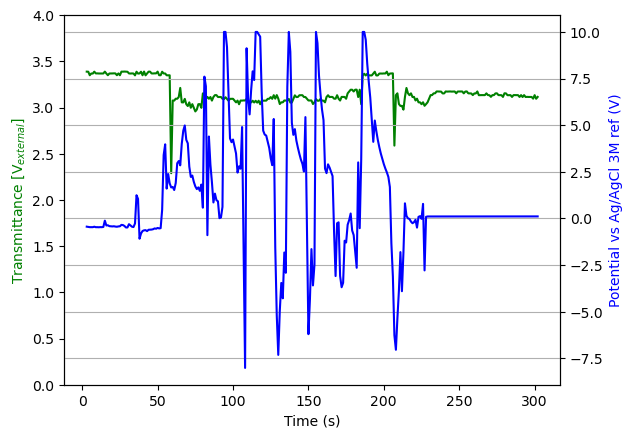

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_A\\images'


<Figure size 1500x600 with 0 Axes>

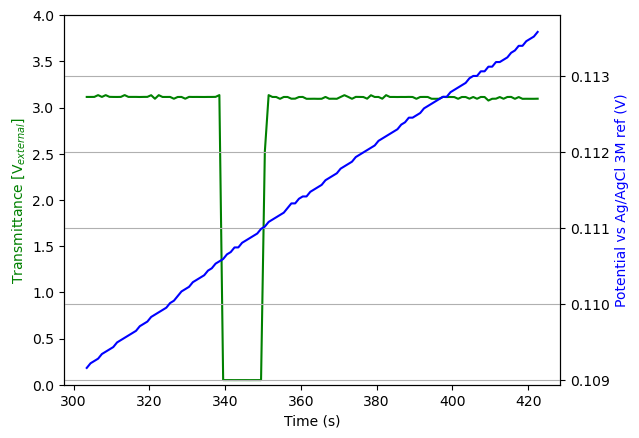

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_A\\images'


<Figure size 1500x600 with 0 Axes>

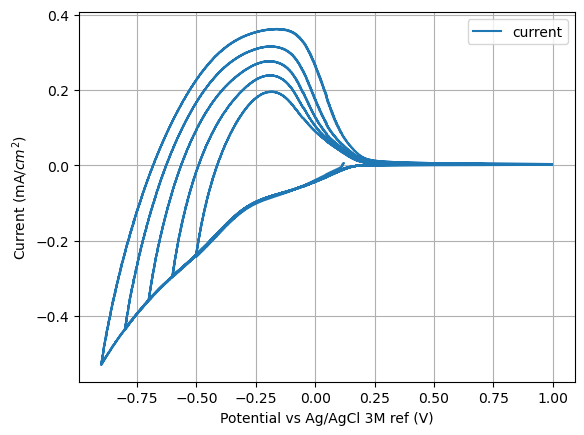

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_A\\images'


<Figure size 1500x600 with 0 Axes>

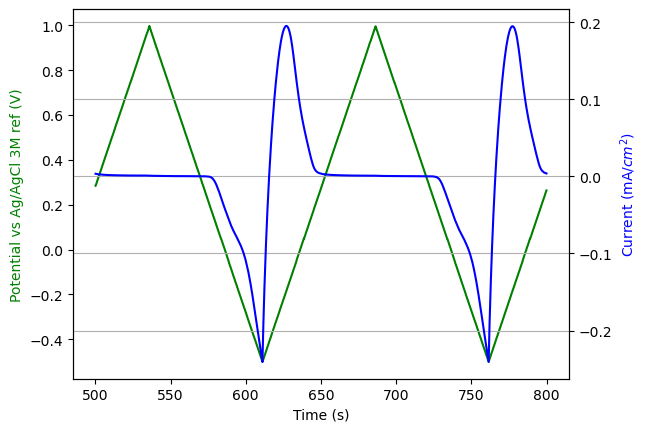

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_A\\images'


<Figure size 1500x600 with 0 Axes>

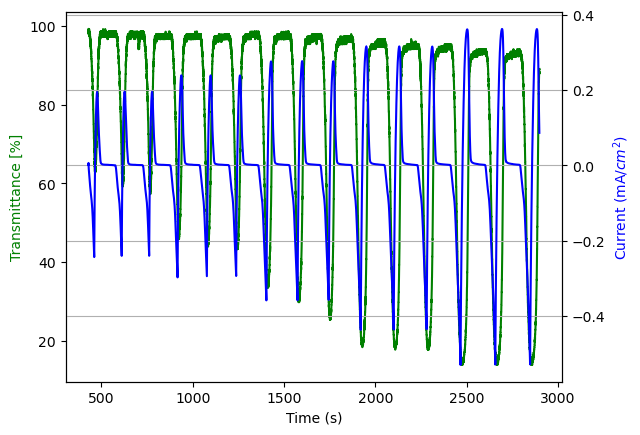

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_A\\images'


<Figure size 1500x600 with 0 Axes>

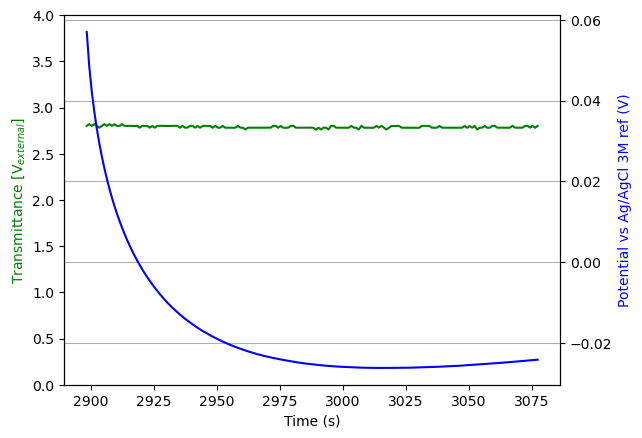

In [47]:
CV_20240424_A()

## 20240424

### CV B

### Analysis of 
- Leaving and entering charge
- Aparent impedance
- Current vs derivative of voltage
- voltage vs derivative of current
- Fourier analysis
- Modelling 

In [48]:
def CV_20240424_A_analysis_2():

    def saveimage2(analysis_name):
            dirname = os.path.join(base_folder, "report", "20240424", "images", "impedance_analysis")
            try:
                os.makedirs(dirname)
            except Exception as e:
                print(e)
            
            
            filename = os.path.join(dirname, f"{analysis_name}.png")
            
            
            
            plt.savefig(filename)
    
    date = "20240424"
    #area cm**2
    film_area = 1.0*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240424","20240424","CV","sample-20240417_A")
    
    CV_2_file = os.path.join(electrochromic_data_folder, "CV_2")
    
    OCP_0_file =  os.path.join(electrochromic_data_folder, "OCP_0")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")

    #
    CV_2 = PotentiostatFile( file_path = CV_2_file, type_of_file = "CV+", date = date, film_area = film_area ) 
    OCP_0 = PotentiostatFile( file_path = OCP_0_file, type_of_file = "OCP+", date = date, film_area = film_area ) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP+", date = date, film_area = film_area ) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP+", date = date, film_area = film_area  ) 

    CV_2_df = CV_2.dataframe
    OCP_0_df = OCP_0.dataframe
    OCP_1_df = OCP_1.dataframe
    OCP_3_df = OCP_3.dataframe

    
    #Leaving and entering charge
    #calculate time difference
    df = CV_2_df
    df["current"] = df["current"]/1000 * film_area
    #df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df['time_delta'] = df['time'].diff()

    #now we multiply the current times the time delta
    df["charge"] = df["current"] * df["time_delta"]
    df["total_charge"] = df['charge'].cumsum()

    plt.figure()
    plt.plot(df["time"], df["current"])
    plt.grid()
    analysis_name = "Current vs time"
    saveimage2(analysis_name)
    plt.show()
    
    plt.figure()
    plt.plot(df["time"], df["total_charge"])
    plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Total charge and transmittance vs time"
    saveimage2(analysis_name)
    plt.show()
    
    #Aparent impedance
    # Z = V/I
    df["impedance"] = df["voltage"] / (df["current"]/1000 * film_area) #ohms

    plt.figure()
    plt.plot(df["time"], df["impedance"])
    #plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Impedance and transmittance vs time"
    saveimage2(analysis_name)
    plt.xlim(500,650)
    plt.ylim(-20,14)
    plt.show()
    
    # V = L di/dt
    df["current_derivative"] = df['current'].diff()
    df["inductance"] = df["voltage"] / df["current_derivative"] #megahenries

    plt.figure()
    plt.plot(df["time"], df["inductance"])
    #plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Inductance and transmittance vs time"
    saveimage2(analysis_name)
    plt.xlim(500,650)
    plt.show()

    # I = C dV/dt

    df["voltage_derivative"] = df['voltage'].diff()
    df["capacitance"] = df["current"] / df["voltage_derivative"] #farads

    plt.figure()
    plt.plot(df["time"], df["capacitance"])
    #plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Capacitance and transmittance vs time"
    saveimage2(analysis_name)
    plt.xlim(500,700)
    plt.ylim(-0.2,0.2)
    plt.show()

    #impedance, inductance and capacitance

    # Create the first plot
    plt.figure()
    plt.subplot(3, 1, 1)  # (rows, columns, panel number)
    plt.plot(df["time"], df["impedance"])
    plt.title('Impedance')
    
    # Create the second plot
    plt.subplot(3, 1, 2)
    plt.plot(df["time"], df["inductance"])
    plt.title('Inductance')

    # Create the second plot
    plt.subplot(3, 1, 3)
    plt.plot(df["time"], df["capacitance"])
    plt.title("Capacitance")
    
    plt.tight_layout()  # Adjust layout to prevent overlapping
    saveimage2(analysis_name)
    plt.show()

    #impedance, inductance and capacitance LIMITED TIME

    # Create the first plot
    plt.figure()
    plt.subplot(3, 1, 1)  # (rows, columns, panel number)
    plt.plot(df["time"], df["impedance"])
    plt.xlim(500, 750)
    plt.ylim(-3E9, 3E9)
    plt.ylabel("Impedance ($\Omega$)")
    #plt.title('Impedance')
    
    # Create the second plot
    plt.subplot(3, 1, 2)
    plt.plot(df["time"], df["inductance"])
    plt.xlim(500, 750)
    #plt.xlim(500, 750)
    #plt.title('Inductance')
    plt.ylabel("Inductance (H)")

    # Create the second plot
    plt.subplot(3, 1, 3)
    plt.plot(df["time"], df["capacitance"])
    plt.xlabel("Time (s)")
    plt.ylabel("Capacitance (F)")
    
    
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.xlim(500, 750)
    plt.ylim(-0.2, 0.2)
    analysis_name = "Omega, L, C vs time"
    #plt.caption("$\Omega$, L and C vs time")
    dirname = os.path.join(base_folder, "report", "20240424", "images", "impedance_analysis")
    saveimage2(analysis_name)
    plt.show()

['time', 'scan', 'voltage', 'current', 'transmittance', 'Q+', 'Q-']
No max and min transmittance info provided
self.max_transmittance=3.1103515625self.min_transmittance=0.477569580078125transmittance_range=2.632781982421875
['time', 'voltage', 'transmittance']
['time', 'voltage', 'transmittance']
['time', 'voltage', 'transmittance']
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\impedance_analysis'


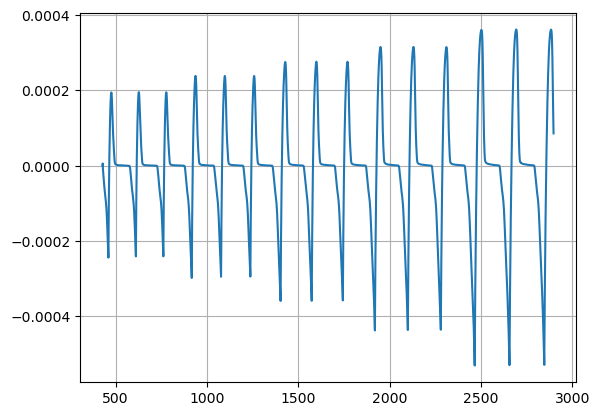

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\impedance_analysis'


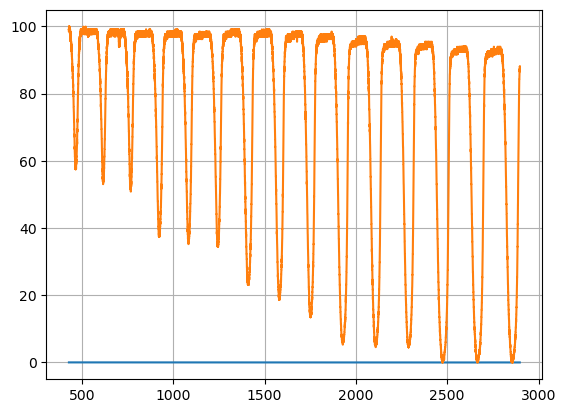

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\impedance_analysis'


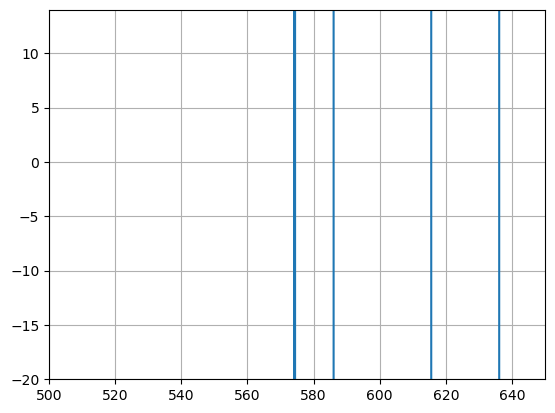

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\impedance_analysis'


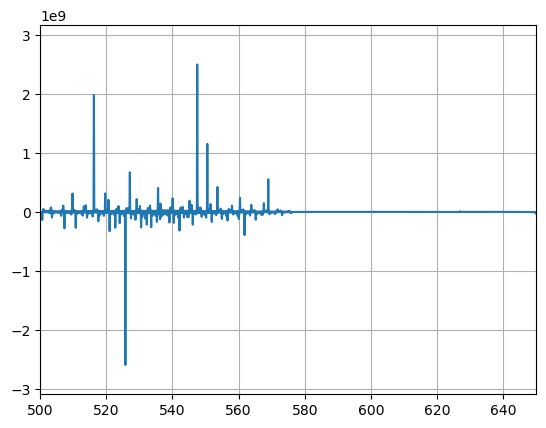

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\impedance_analysis'


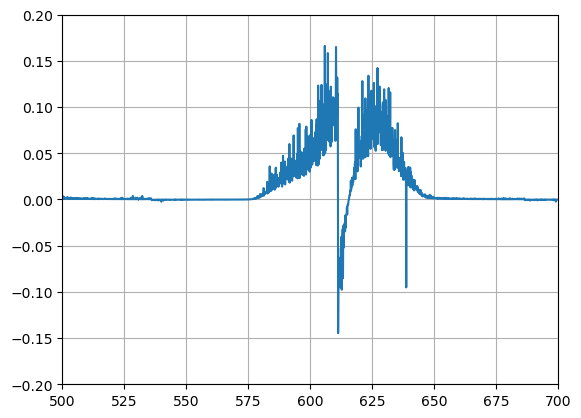

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\impedance_analysis'


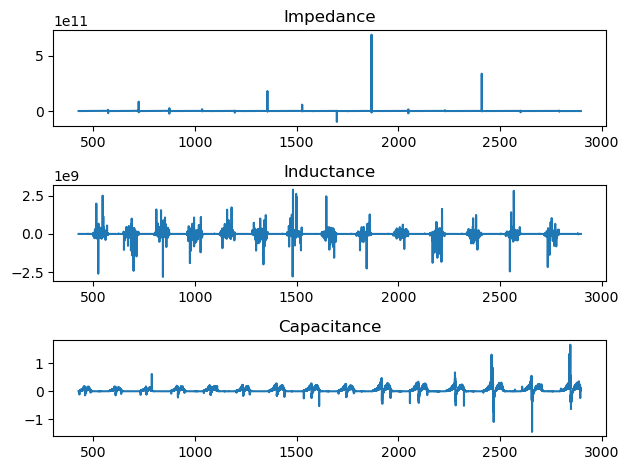

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\impedance_analysis'


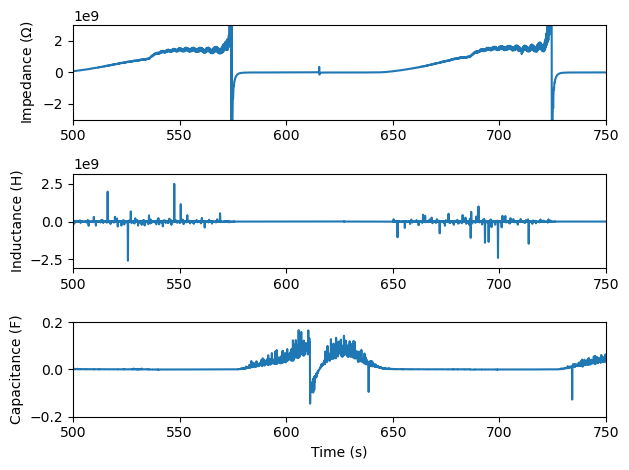

In [49]:
CV_20240424_A_analysis_2()

In [50]:
def CV_20240424_A_analysis_3():

    def saveimage2(analysis_name):
            dirname = os.path.join(base_folder, "report", "20240424", "images", "energy_analysis")
            try:
                os.makedirs(dirname)
            except Exception as e:
                print(e)
            
            filename = os.path.join(dirname, f"{analysis_name} .png")
            
            
            plt.savefig(filename)
    
    date = "20240424"
    #area cm**2
    film_area = 1.0*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240424","20240424","CV","sample-20240417_A")
    
    CV_2_file = os.path.join(electrochromic_data_folder, "CV_2")
    
    OCP_0_file =  os.path.join(electrochromic_data_folder, "OCP_0")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")

    #
    CV_2 = PotentiostatFile( file_path = CV_2_file, type_of_file = "CV+", date = date, film_area = film_area ) 
    OCP_0 = PotentiostatFile( file_path = OCP_0_file, type_of_file = "OCP+", date = date, film_area = film_area ) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP+", date = date, film_area = film_area ) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP+", date = date, film_area = film_area  ) 

    CV_2_df = CV_2.dataframe
    OCP_0_df = OCP_0.dataframe
    OCP_1_df = OCP_1.dataframe
    OCP_3_df = OCP_3.dataframe

    
    #Leaving and entering charge
    #calculate time difference
    df = CV_2_df
    #print(df)

    #calculate current 
    df["current"] = df["current"]/1000 * film_area
    #df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df['time_delta'] = df['time'].diff()

    #now we multiply the current times the time delta
    df["charge"] = df["current"] * df["time_delta"]
    df["total_charge"] = df['charge'].cumsum()

    #calculate power
    df["power"] = df["current"] * df["voltage"]
    
    plt.figure(figsize =(8, 5))
    plt.plot(df["time"], df["power"])
    #plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Power vs time"
    #saveimage2(analysis_name)
    #plt.xlim(500,650)
    #plt.ylim(-20,14)
    plt.xlabel("Time (s)")
    plt.ylabel("Power (W)")
    print(analysis_name)
    saveimage2(analysis_name)
    plt.show()

    #Now we are going to calculate the energy that enters, exits the system
    #Instantaneous and total 
    #calculate power
    df["instant_energy"] = df["power"] * df["time_delta"]
    
    plt.figure()
    plt.plot(df["time"], df["instant_energy"])
    #plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Instantaneous energy vs time"
    #saveimage2(analysis_name)
    #plt.xlim(500,650)
    #plt.ylim(-20,14)
    plt.xlabel("Time (s)")
    plt.ylabel("Instantaneous energy (J)")
    print(analysis_name)
    saveimage2(analysis_name)
    plt.show()

    #total energy
    df["total_energy"] = df["power"].cumsum()
    
    plt.figure()
    
    # Create figure and primary axis
    fig, ax1 = plt.subplots()
    x_val = df["time"]
    y_val = df["total_energy"]
    y2_val = df["transmittance"]
    
    # Plot data on primary axis
    ax1.plot(x_val, y_val, 'b')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Total energy (J)", color='b')
    
    # Create secondary axis
    ax2 = ax1.twinx()
    
    # Plot data on secondary axis
    ax2.plot(x_val, y2_val, 'g')
    ax2.set_ylabel("Transmittance [%]", color='g')
                   
    #plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Total energy applied and transmittance vs time"
    
    #plt.xlim(500,650)
    #plt.ylim(-20,14)
    
    print(analysis_name)
    saveimage2(analysis_name)
    plt.show()

    #############################################
    # Create figure and primary axis
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    x_val = df["time"]
    y_val = df["total_energy"]
    y2_val = df["total_charge"]
    
    # Plot data on primary axis
    ax1.plot(x_val, y_val, 'b')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Total energy (J)", color='b')
    
    # Create secondary axis
    ax2 = ax1.twinx()
    
    # Plot data on secondary axis
    ax2.plot(x_val, y2_val, 'g')
    ax2.set_ylabel("Total charge [C]", color='g')
                   
    #plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Total energy applied and total charge inserted vs time"
    
    #plt.xlim(500,650)
    #plt.ylim(-20,14)
    
    print(analysis_name)
    saveimage2(analysis_name)
    plt.show()
    

['time', 'scan', 'voltage', 'current', 'transmittance', 'Q+', 'Q-']
No max and min transmittance info provided
self.max_transmittance=3.1103515625self.min_transmittance=0.477569580078125transmittance_range=2.632781982421875
['time', 'voltage', 'transmittance']
['time', 'voltage', 'transmittance']
['time', 'voltage', 'transmittance']
Power vs time
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\energy_analysis'


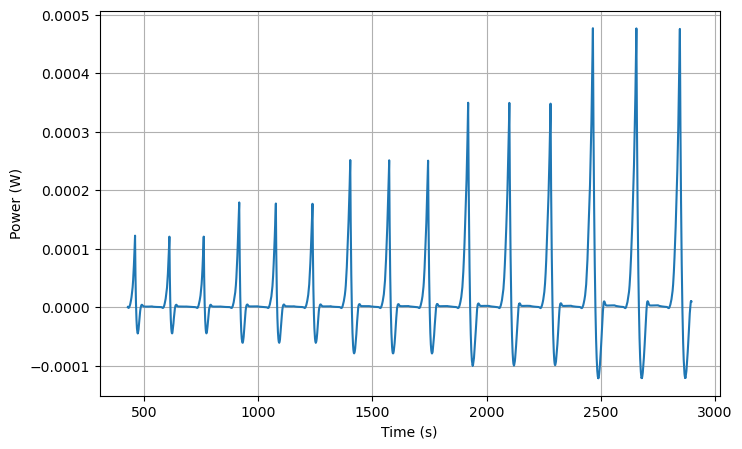

Instantaneous energy vs time
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\energy_analysis'


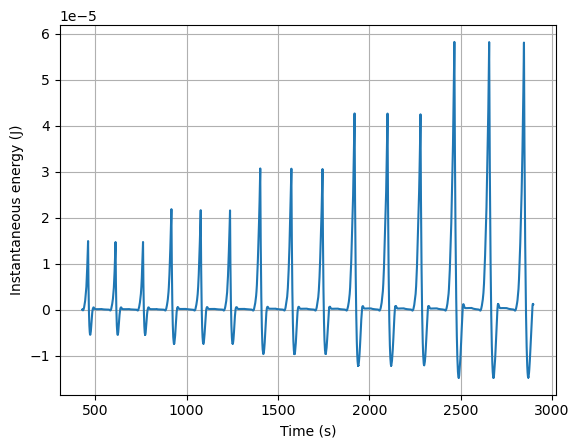

Total energy applied and transmittance vs time
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\energy_analysis'


<Figure size 640x480 with 0 Axes>

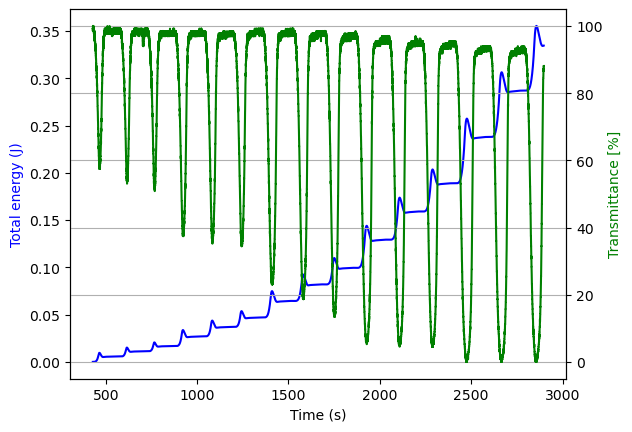

Total energy applied and total charge inserted vs time
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\report\\20240424\\images\\energy_analysis'


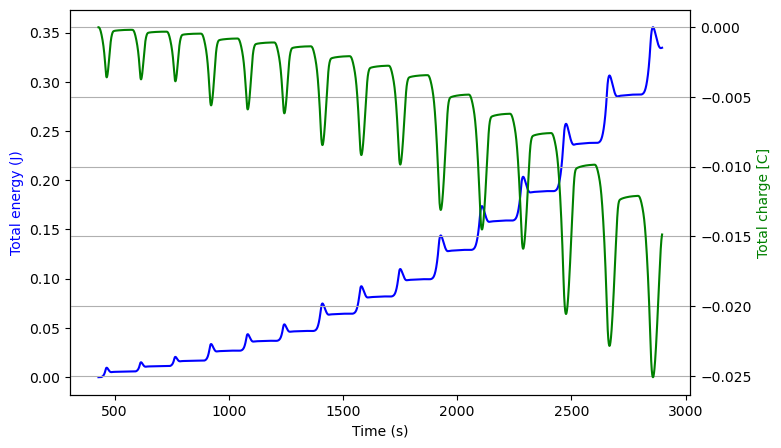

In [51]:
CV_20240424_A_analysis_3()

In [52]:
def CV_20240424_A_analysis_4():

    def saveimage2(analysis_name):
            dirname = os.path.join(base_folder, "report", "20240424", "images", "energy_analysis")
            try:
                os.makedirs(dirname)
            except Exception as e:
                print(e)
            
            filename = os.path.join(dirname, f"{analysis_name} .png")
            
            
            plt.savefig(filename)
    
    date = "20240424"
    #area cm**2
    film_area = 1.0*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240424","20240424","CV","sample-20240417_A")
    
    CV_2_file = os.path.join(electrochromic_data_folder, "CV_2")
    
    OCP_0_file =  os.path.join(electrochromic_data_folder, "OCP_0")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")

    #
    CV_2 = PotentiostatFile( file_path = CV_2_file, type_of_file = "CV+", date = date, film_area = film_area ) 
    OCP_0 = PotentiostatFile( file_path = OCP_0_file, type_of_file = "OCP+", date = date, film_area = film_area ) 
    OCP_1 = PotentiostatFile( file_path = OCP_1_file, type_of_file = "OCP+", date = date, film_area = film_area ) 
    OCP_3 = PotentiostatFile( file_path = OCP_3_file, type_of_file = "OCP+", date = date, film_area = film_area  ) 

    CV_2_df = CV_2.dataframe
    OCP_0_df = OCP_0.dataframe
    OCP_1_df = OCP_1.dataframe
    OCP_3_df = OCP_3.dataframe

    
    #Leaving and entering charge
    #calculate time difference
    df = CV_2_df
    #print(df)

    #calculate current 
    df["current"] = df["current"]/1000 * film_area
    #df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df['time_delta'] = df['time'].diff()

    #now we multiply the current times the time delta
    df["charge"] = df["current"] * df["time_delta"]
    df["total_charge"] = df['charge'].cumsum()

    #calculate power
    df["power"] = df["current"] * df["voltage"]
    
   

    #Now we are going to calculate the energy that enters, exits the system
    #Instantaneous and total 
    #calculate power
    df["instant_energy"] = df["power"] * df["time_delta"]
    

    #total energy
    df["total_energy"] = df["power"].cumsum()
    
    
    #plt.xlim(500,650)
    #plt.ylim(-20,14)
    
    print(analysis_name)
    saveimage2(analysis_name)
    plt.show()

    #############################################
    # Create figure and primary axis
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    x_val = df["time"]
    y_val = df["total_energy"]
    y2_val = df["total_charge"]
    
    # Plot data on primary axis
    ax1.plot(x_val, y_val, 'b')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Total energy (J)", color='b')
    
    # Create secondary axis
    ax2 = ax1.twinx()
    
    # Plot data on secondary axis
    ax2.plot(x_val, y2_val, 'g')
    ax2.set_ylabel("Total charge [C]", color='g')
                   
    #plt.plot(df["time"], df["transmittance"])
    plt.grid()
    analysis_name = "Total energy applied and total charge inserted vs time"
    
    #plt.xlim(500,650)
    #plt.ylim(-20,14)
    
    print(analysis_name)
    saveimage2(analysis_name)
    plt.show()
    

In [53]:
## 20240424

### cv B

def CV_20240424_B():
    
    date = "20240424"
    #area cm**2
    film_area = 1.0*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240424","20240424","CV","sample-20240417_B")
    
    
    CV_2_file = os.path.join(electrochromic_data_folder, "CV_2")
    
    OCP_0_file =  os.path.join(electrochromic_data_folder, "OCP_0")
    OCP_1_file =  os.path.join(electrochromic_data_folder, "OCP_1")
    OCP_3_file =  os.path.join(electrochromic_data_folder, "OCP_3")
    
    #optical_data_folder = r"C:\Users\esteb\electrochromicfilms\Edgar\20230913\20230913"
    #optical_1_file = os.path.join(optical_data_folder, "550nm.dat")
    
    #read files
    #print dataframes
    
    #print(chronoamperommetry_steps.dataframe)
    #print(OCP_1.dataframe)
    #print(OCP_3.dataframe)
    
    
    #Analysis
    
    cv_analysis(OCP_0_file, OCP_1_file, CV_2_file, OCP_3_file, date, film_area)

['time', 'voltage', 'transmittance']
['time', 'voltage', 'transmittance']
['time', 'voltage', 'transmittance']
['time', 'scan', 'voltage', 'current', 'transmittance', 'Q+', 'Q-']
self.max_transmittance=3.46588134765625self.min_transmittance=0.049896240234375transmittance_range=3.415985107421875
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_B\\images'


<Figure size 1500x600 with 0 Axes>

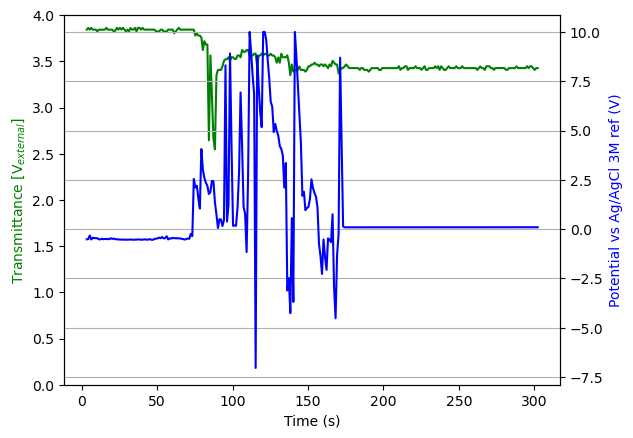

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_B\\images'


<Figure size 1500x600 with 0 Axes>

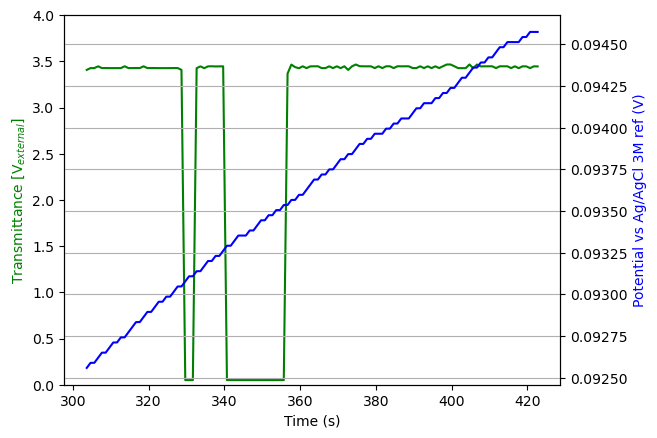

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_B\\images'


<Figure size 1500x600 with 0 Axes>

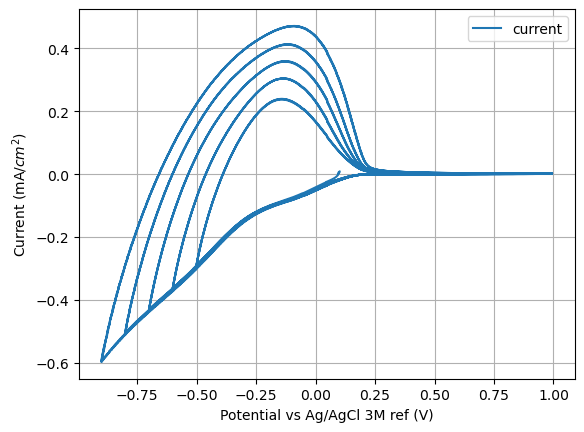

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_B\\images'


<Figure size 1500x600 with 0 Axes>

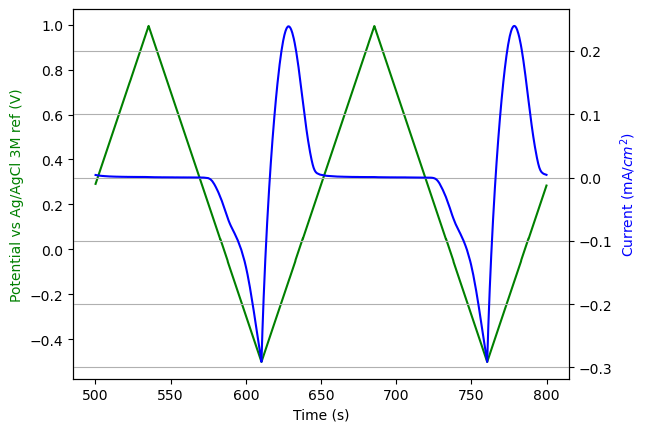

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_B\\images'


<Figure size 1500x600 with 0 Axes>

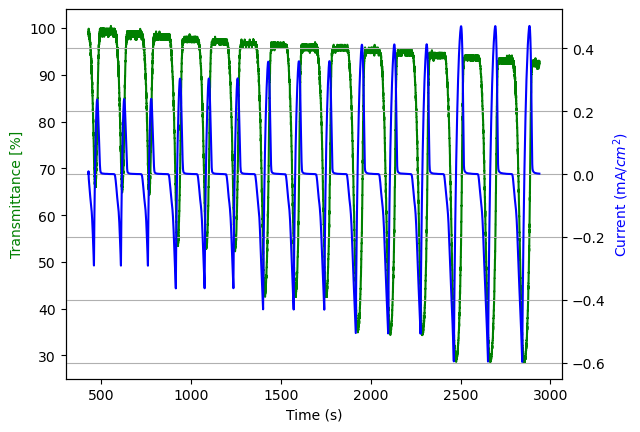

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\Edgar\\20240424\\20240424\\CV\\sample-20240417_B\\images'


<Figure size 1500x600 with 0 Axes>

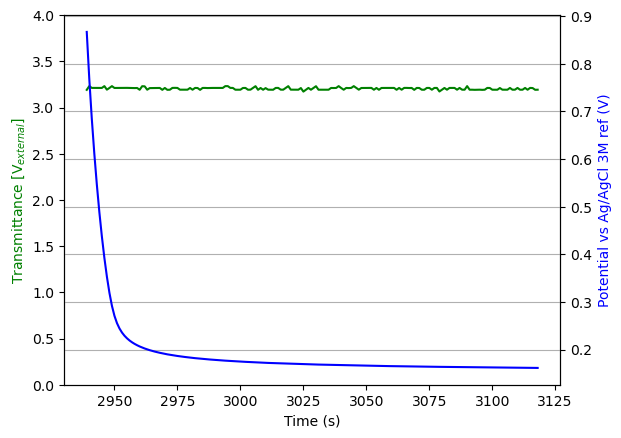

In [54]:
CV_20240424_B()

In [55]:
# 2024 05 15
# 

cv1_df
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

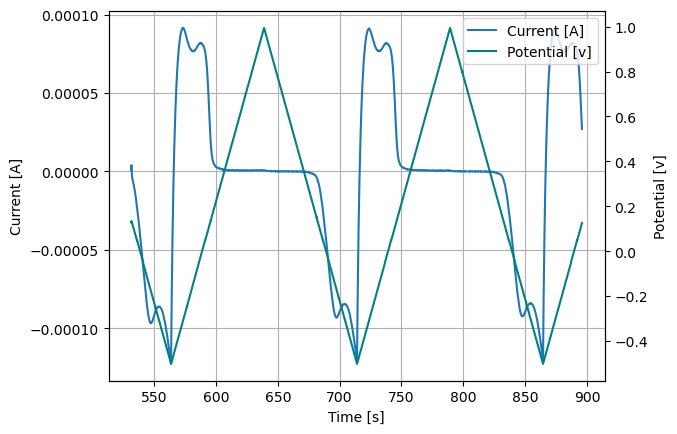

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

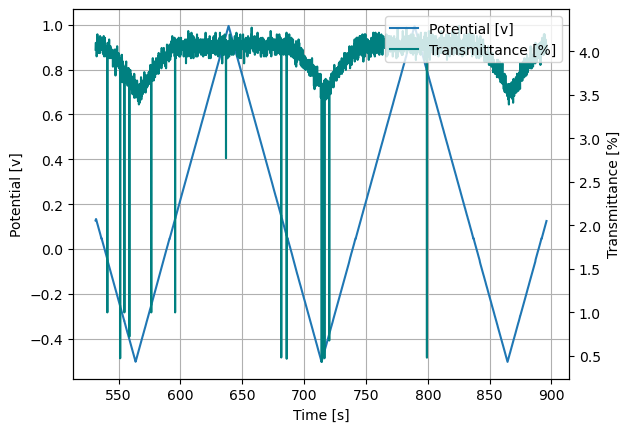

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

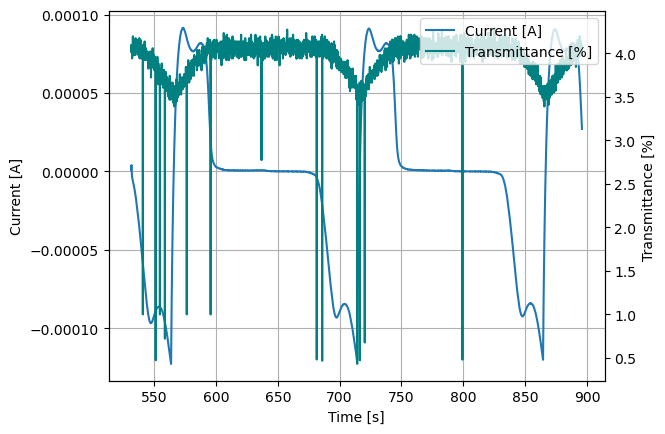

cv2_df
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

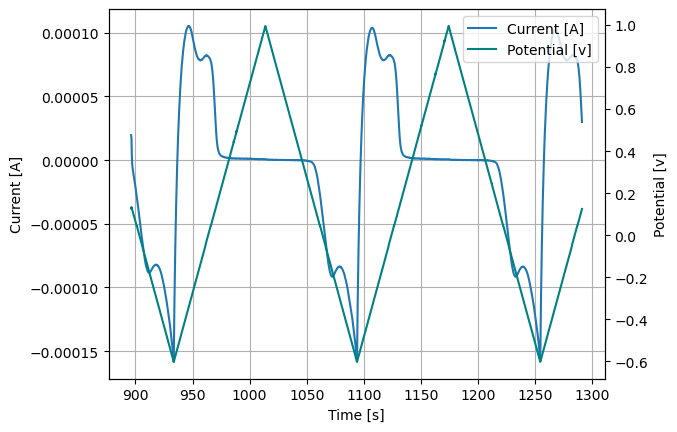

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

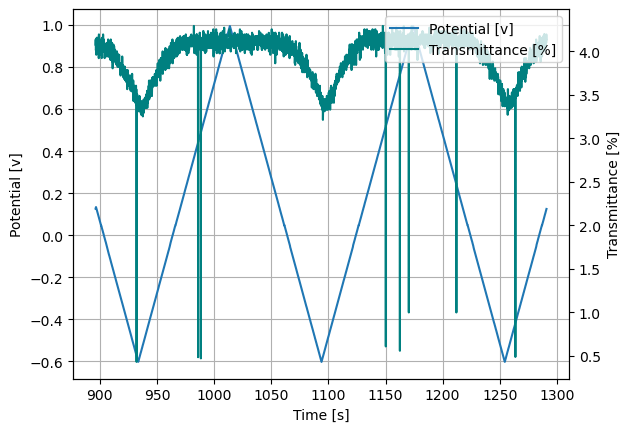

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

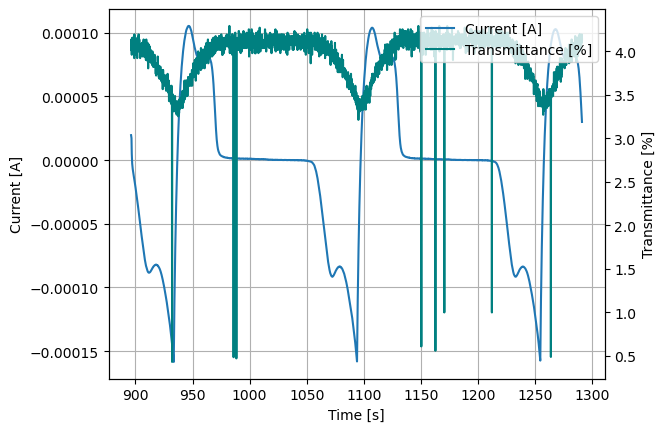

cv3_df
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

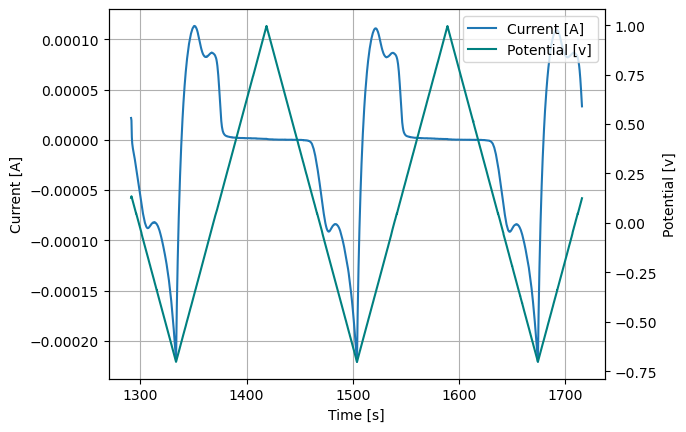

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

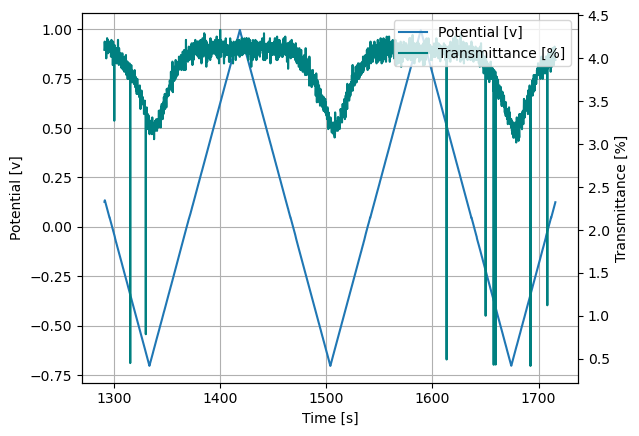

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

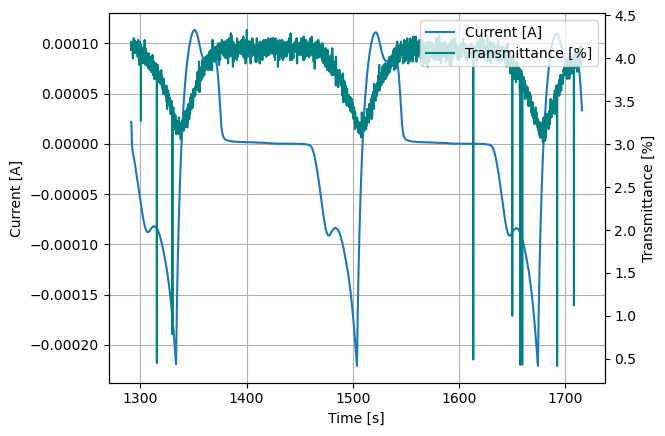

cv4_df
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

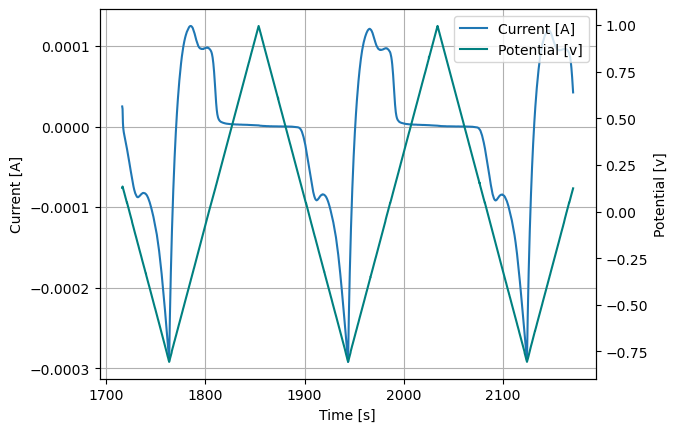

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

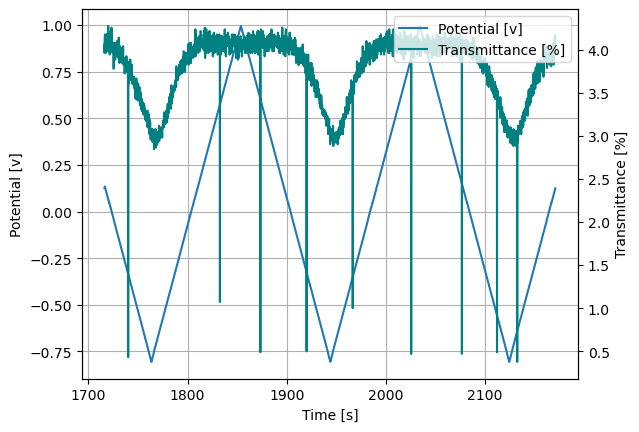

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

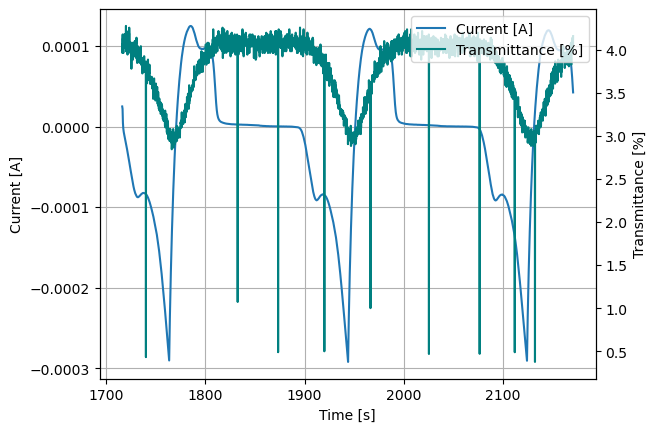

cv5_df
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

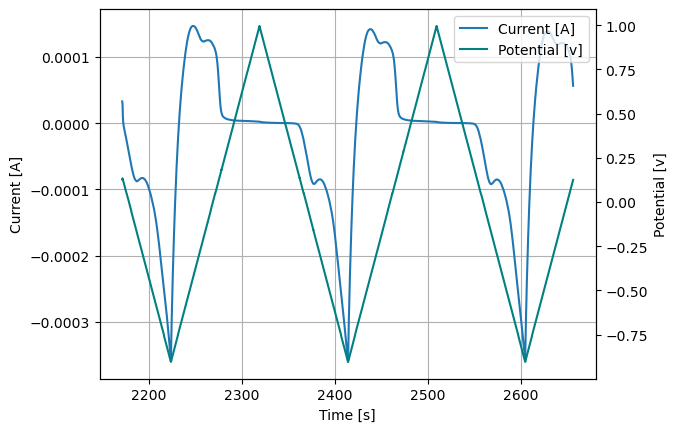

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

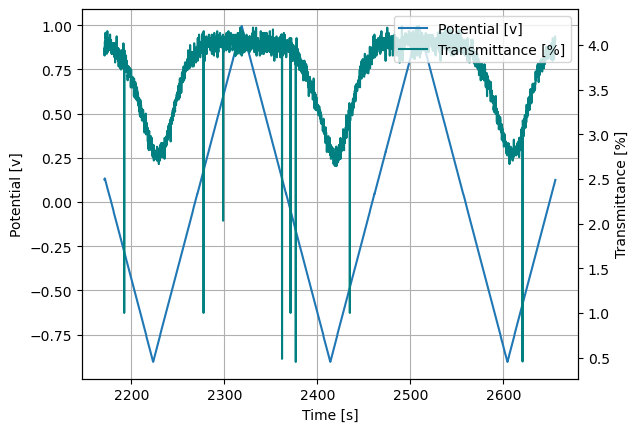

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

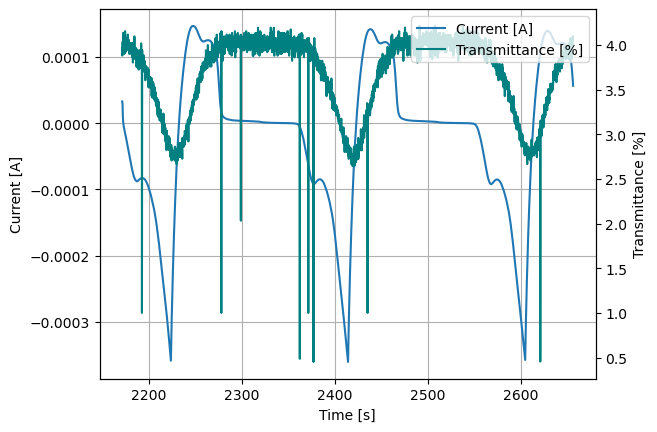

In [75]:
def CV_20240515_B_CV():
    
    date = "20240515"
    #area cm**2
    film_area = 1.0*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240515","20240515","EC_measurements","Sample_20240502_B", "CV", "data")
    
    cv1f= os.path.join(electrochromic_data_folder, "CV_1")
    cv2f= os.path.join(electrochromic_data_folder, "CV_2")
    cv3f= os.path.join(electrochromic_data_folder, "CV_3")
    cv4f= os.path.join(electrochromic_data_folder, "CV_4")
    cv5f= os.path.join(electrochromic_data_folder, "CV_5")

    cv1_df = pd.read_csv(cv1f, delimiter = "\t", header = 0, names= ["time","scan", "potential","current", "transmittance", "Q+", "Q-"])
    cv2_df = pd.read_csv(cv2f, delimiter = "\t", header = 0, names= ["time","scan", "potential","current", "Q+", "Q-", "transmittance"])
    cv3_df = pd.read_csv(cv3f, delimiter = "\t", header = 0, names= ["time","scan", "potential","current", "Q+", "Q-", "transmittance"])
    cv4_df = pd.read_csv(cv4f, delimiter = "\t", header = 0, names= ["time","scan", "potential","current", "Q+", "Q-", "transmittance"])
    cv5_df = pd.read_csv(cv5f, delimiter = "\t", header = 0, names= ["time","scan", "potential","current", "Q+", "Q-", "transmittance"])
    
    cv1_df = cv1_df.astype(float)
    cv2_df = cv2_df.astype(float)
    cv3_df = cv3_df.astype(float)
    cv4_df = cv4_df.astype(float)
    cv5_df = cv5_df.astype(float)

    #potential and current
    
    time1 = cv1_df["time"]
    potential1 = cv1_df["potential"]
    current1 = cv1_df["current"]
    transmittance1 = cv1_df["transmittance"]
    max_t_signal = transmittance1.max()
    transmittance1norm = transmittance1

    def create_figure_two_axes(x, y1, y2, xlabel, ylabel1, ylabel2):
        
        plt.figure()
        fig, ax1 = plt.subplots()    
        ax1.plot(x, y1, label= f"{ylabel1}")
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel1)
    
        
        ax2 = ax1.twinx()
        ax2.plot(x, y2, color = "teal", label=f"{ylabel2}")
        ax2.set_ylabel(ylabel2)
        
        ax1.grid(True)
    
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        
        folder = os.path.join(base_folder, r"20240515", "impedance")
        folder_filename = os.path.join(folder, f"sample_20240502_B_{ylabel1}_and_{ylabel2}.png")
        try:
            os.makedirs(folder)
        except Exception as e:
            print(e)
        #plt.savefig(folder_filename)
        plt.show()
    

    #current and transmittance
    def get_cv_figures(time, current, potential, transmittance, qplus, qminus):
        create_figure_two_axes(x=time, y1=current, y2=potential, xlabel="Time [s]", ylabel1="Current [A]", ylabel2="Potential [v]")
        create_figure_two_axes(x=time, y1=potential, y2 =transmittance, xlabel="Time [s]", ylabel1="Potential [v]", ylabel2="Transmittance [%]")
        create_figure_two_axes(x=time, y1=current, y2 =transmittance, xlabel="Time [s]", ylabel1="Current [A]", ylabel2="Transmittance [%]")
        #create_figure_two_axes(x=time, y1=qplus, y2 =transmittance, xlabel="Time [s]", ylabel1="Q+ [C]", ylabel2="Transmittance [%]")
        #create_figure_two_axes(x=time, y1=qminus, y2 =transmittance, xlabel="Time [s]", ylabel1="Q- [%]", ylabel2="Transmittance [%]")
        #create_figure_two_axes(x=time, y1=current, y2 = qplus, xlabel="Time [s]", ylabel1="Current [A]", ylabel2="Q+")
        #create_figure_two_axes(x=time, y1=current, y2 = qminus, xlabel="Time [s]", ylabel1="Current [A]", ylabel2="Q-")
        
    def get_cv_complete_analysis(cv_df):
        time = cv_df["time"]
        potential = cv_df["potential"]
        current = cv_df["current"]
        transmittance = cv_df["transmittance"]
        qplus = cv_df["Q+"]
        qminus = cv_df["Q-"]
        #max_t_signal = transmittance.max()
        get_cv_figures(time = time, current= current, potential = potential, transmittance= transmittance, qplus = qplus, qminus = qminus)
        
    print("cv1_df")
    get_cv_complete_analysis(cv1_df)
    print("cv2_df")
    get_cv_complete_analysis(cv2_df)
    print("cv3_df")
    get_cv_complete_analysis(cv3_df)
    print("cv4_df")
    get_cv_complete_analysis(cv4_df)
    print("cv5_df")
    get_cv_complete_analysis(cv5_df)
    
    
    
CV_20240515_B_CV()

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'
       frequency             Zp           Zpp              Z      phase  \
0   10000.000000     446.089211     34.274458     447.403982   4.393586   
1    7943.300000     300.670922     24.714503     301.684952   4.699026   
2    6309.600000     301.764916     22.372328     302.593102   4.240053   
3    5011.900000     302.764127     20.916566     303.485781   3.952020   
4    3981.100000     303.914054     20.251071     304.588014   3.812223   
..           ...            ...           ...            ...        ...   
56      0.025119   42887.953227  63752.565938   76835.969413  56.070287   
57      0.019953   55781.548005  71258.693590   90495.207111  51.946040   
58      0.015849   70666.026674  77010.213391  104519.186241  47.459920   
59      0.012589   88267.548218  80161.806107  119235.377413  42.244739   
60      0.010000  105869.357216  79565.99

<Figure size 640x480 with 0 Axes>

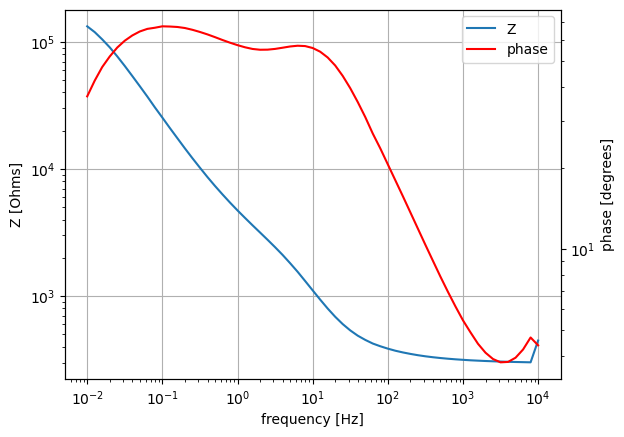

In [74]:
def CV_20240515_B_EIS():
    
    date = "20240515"
    #area cm**2
    film_area = 1.0*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240515","20240515","EC_measurements","Sample_20240502_B", "EIS", "data")
    
    impedance_file= os.path.join(electrochromic_data_folder, "EIS_WO3_ITO_20240502_B_0p2V_vs_ref")
    imp_df = pd.read_csv(impedance_file, delimiter = "\t", header = 0, names= ["frequency", "Zp", "Zpp", "Z", "phase", "time"])
    imp_df = imp_df.astype(float)

    #Z and phase vs frequency
    
    frequency = imp_df["frequency"].values
    Z = imp_df["Z"].values
    Zp = imp_df["Zp"].values
    Zpp = imp_df["Zpp"].values
    phase = imp_df["phase"].values

    plt.figure()
    fig, ax1 = plt.subplots()    
    ax1.loglog(frequency, Z, label= "Z")
    ax1.set_ylabel("Z [Ohms]")

    ax2 = ax1.twinx()
    ax2.semilogy(frequency, phase, color = "r", label="phase")
    ax2.set_ylabel("phase [degrees]")
    ax1.set_xlabel("frequency [Hz]")
    ax1.grid(True)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    
    folder = os.path.join(base_folder, r"20240515", "impedance")
    folder_filename = os.path.join(folder, "sample_20240502_B_phase_and_impedance.png")
    try:
        os.makedirs(folder)
    except Exception as e:
        print(e)
    plt.savefig(folder_filename)

    print(imp_df)
    
CV_20240515_B_EIS()

ocp1_df
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

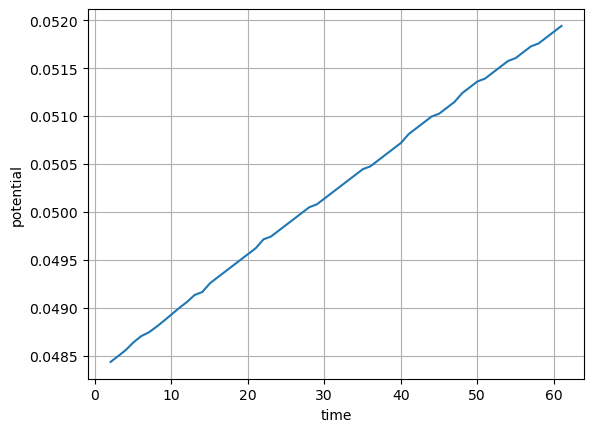

ocp3_df
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

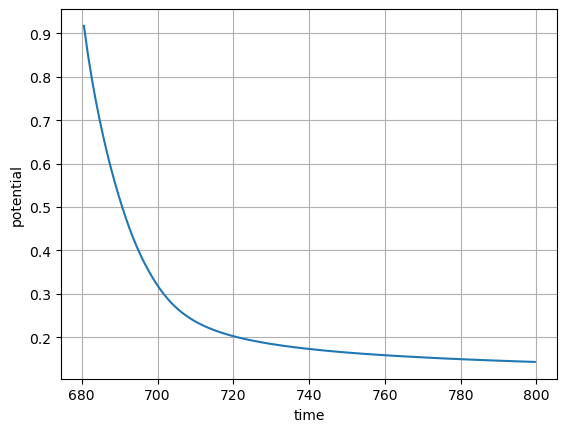

steps_df
[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

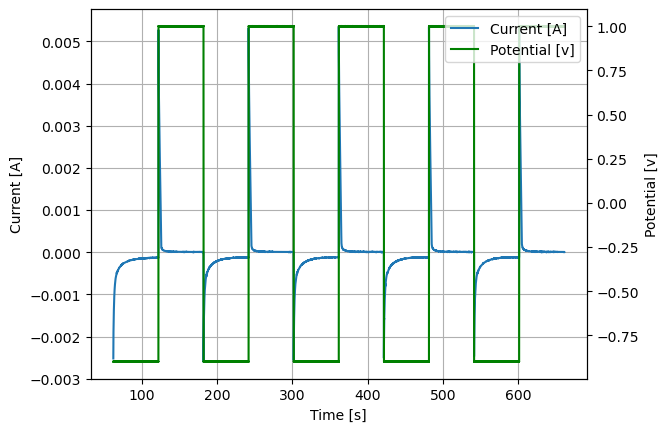

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

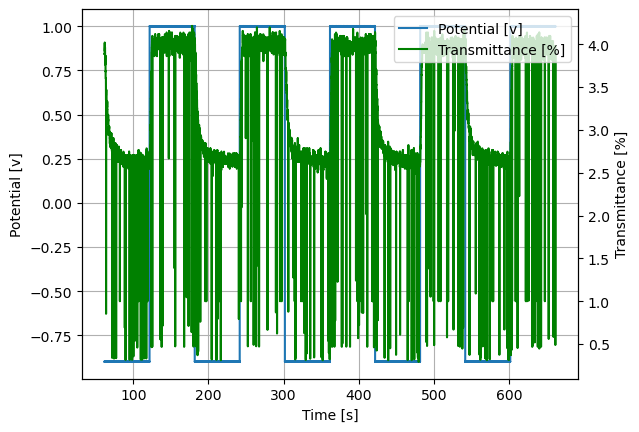

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\EstebanSoto\\electrochromicfilms\\20240515\\impedance'


<Figure size 640x480 with 0 Axes>

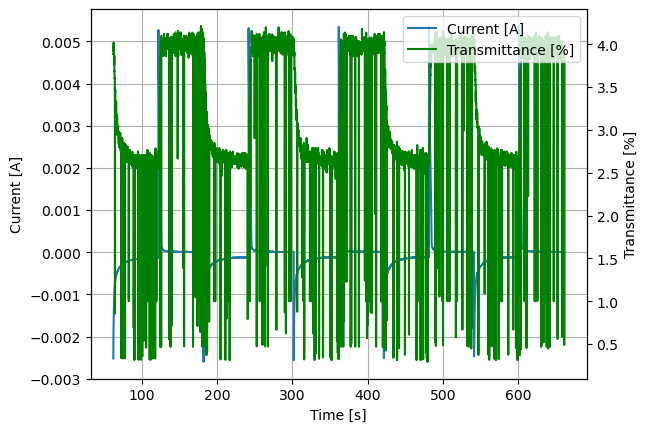

In [80]:
def CV_20240515_B_STEPS():
    
    date = "20240515"
    #area cm**2
    film_area = 1.0*1 #cm**2
    
    electrochromic_data_folder = os.path.join(base_folder, r"Edgar","20240515","20240515","EC_measurements","Sample_20240502_B", "steps", "data")
    
    ocp1f= os.path.join(electrochromic_data_folder, "OCP_1")
    ocp3f= os.path.join(electrochromic_data_folder, "OCP_3")
    stepsf= os.path.join(electrochromic_data_folder, "pulses_steps_m0p9V_1V.txt")

    ocp1_df = pd.read_csv(ocp1f, delimiter = "\t", header = 0, names= ["time", "potential"])
    ocp3_df = pd.read_csv(ocp3f, delimiter = "\t", header = 0, names= ["time", "potential"])
    steps_df = pd.read_csv(stepsf, delimiter = "\t", header = 0, names= ["time", "potential","current", "transmittance"])
    
    ocp1_df = ocp1_df.astype(float)
    ocp3_df = ocp3_df.astype(float)
    steps_df = steps_df.astype(float)


    
    
    def create_figure_one_axis(x, y1,  xlabel, ylabel1):
        
        plt.figure()
        fig, ax1 = plt.subplots()    
        ax1.plot(x, y1, label= f"{ylabel1}")
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel1)
    
        ax1.grid(True)
    
        folder = os.path.join(base_folder, r"20240515", "impedance")
        folder_filename = os.path.join(folder, f"sample_20240502_B_{ylabel1}.png")
        try:
            os.makedirs(folder)
        except Exception as e:
            print(e)
        #plt.savefig(folder_filename)
        plt.show()
        
    def create_figure_two_axes(x, y1, y2, xlabel, ylabel1, ylabel2):
        
        plt.figure()
        fig, ax1 = plt.subplots()    
        ax1.plot(x, y1, label= f"{ylabel1}")
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel1)
    
        
        ax2 = ax1.twinx()
        ax2.plot(x, y2, color = "green", label=f"{ylabel2}")
        ax2.set_ylabel(ylabel2)
        
        ax1.grid(True)
    
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        
        folder = os.path.join(base_folder, r"20240515", "impedance")
        folder_filename = os.path.join(folder, f"sample_20240502_B_{ylabel1}_and_{ylabel2}.png")
        try:
            os.makedirs(folder)
        except Exception as e:
            print(e)
        #plt.savefig(folder_filename)
        plt.show()
    

    #current and transmittance
    def get_cv_figures(time, current, potential, transmittance):
        create_figure_two_axes(x=time, y1=current, y2=potential, xlabel="Time [s]", ylabel1="Current [A]", ylabel2="Potential [v]")
        create_figure_two_axes(x=time, y1=potential, y2 =transmittance, xlabel="Time [s]", ylabel1="Potential [v]", ylabel2="Transmittance [%]")
        create_figure_two_axes(x=time, y1=current, y2 =transmittance, xlabel="Time [s]", ylabel1="Current [A]", ylabel2="Transmittance [%]")
        #create_figure_two_axes(x=time, y1=qplus, y2 =transmittance, xlabel="Time [s]", ylabel1="Q+ [C]", ylabel2="Transmittance [%]")
        #create_figure_two_axes(x=time, y1=qminus, y2 =transmittance, xlabel="Time [s]", ylabel1="Q- [%]", ylabel2="Transmittance [%]")
        #create_figure_two_axes(x=time, y1=current, y2 = qplus, xlabel="Time [s]", ylabel1="Current [A]", ylabel2="Q+")
        #create_figure_two_axes(x=time, y1=current, y2 = qminus, xlabel="Time [s]", ylabel1="Current [A]", ylabel2="Q-")

    def get_ocp_complete_analysis(ocp_df):
        time = ocp_df["time"]
        potential = ocp_df["potential"]
        create_figure_one_axis(time, potential,  "time", "potential")
    
    def get_steps_complete_analysis(steps_df):
        time = steps_df["time"]
        potential = steps_df["potential"]
        current = steps_df["current"]
        transmittance = steps_df["transmittance"]
        get_cv_figures(time = time, current= current, potential = potential, transmittance= transmittance)
        
    def get_cv_complete_analysis(cv_df):
        time = cv_df["time"]
        potential = cv_df["potential"]
        current = cv_df["current"]
        transmittance = cv_df["transmittance"]
        qplus = cv_df["Q+"]
        qminus = cv_df["Q-"]
        #max_t_signal = transmittance.max()
        get_cv_figures(time = time, current= current, potential = potential, transmittance= transmittance)


    
    print("ocp1_df")
    get_ocp_complete_analysis(ocp1_df)
    print("ocp3_df")
    get_ocp_complete_analysis(ocp3_df)
    print("steps_df")
    get_steps_complete_analysis(steps_df)
    
CV_20240515_B_STEPS()    